# IMDB Review Sentiment Analysis


Data source: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format

Code adapted from: https://www.kaggle.com/code/miladlink/imdb-sentiment-analysis-pytorch

In [1]:
#!conda install -c conda-forge spacy
#or
#!pip install -U pip setuptools wheel
#!pip install -U spacy

#then
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

import os, sys, re
import time
import copy
import pickle
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from models import LSTM, GRU, AttentionLSTM, Transformer

import spacy
# setup
NLP = spacy.load('en_core_web_sm')  # NLP toolkit

In [2]:
path = os.path.abspath(os.getcwd())
path_para = path+'/para'
if not os.path.exists(path_para):
    os.makedirs(path_para)

In [3]:
#initialize for random seeds/states
seeds=[12345,42,42]
def randomize(seed_rng=seeds[0], seed_np=seeds[1], seed_torch=seeds[2]):
    os.environ['PYTHONHASHSEED'] = '0'
    rng = np.random.default_rng(seed_rng)
    np.random.seed(seed_np)
    torch.manual_seed(seed_torch)

randomize()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Explore data

In [5]:
# Read dataset
train_df = pd.read_csv("data/Train.csv")
valid_df = pd.read_csv("data/Valid.csv")
test_df = pd.read_csv("data/Test.csv")

In [6]:
print('number of train:', len(train_df))
print('number of valid:', len(valid_df))
print('number of test:', len(test_df))
train_df.head(3)

number of train: 40000
number of valid: 5000
number of test: 5000


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0


/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

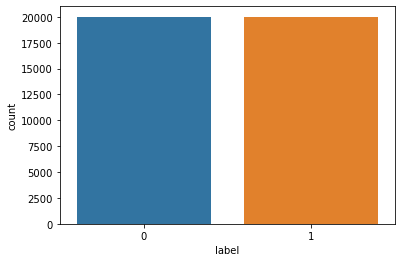

In [7]:
sns.countplot(train_df['label'])

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

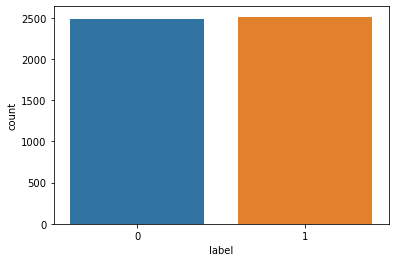

In [8]:
sns.countplot(valid_df['label'])

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

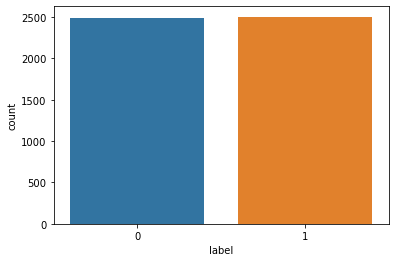

In [9]:
sns.countplot(test_df['label'])

In [10]:
num_words = [len(f.split(' ')) for f in train_df['text']]

# print statistics
print('Min length =', min(num_words))
print('Max length =', max(num_words))

print('Mean = {:.2f}'.format(np.mean(num_words)))
print('Std  = {:.2f}'.format(np.std(num_words)))

print('mean + 1 * sigma = {:.2f}'.format(np.mean(num_words) + 1.0 * np.std(num_words)))

Min length = 4
Max length = 2470
Mean = 231.33
Std  = 171.18
mean + 1 * sigma = 402.51


## Tokenize

In [11]:
use_stopwords = True
stopwords = NLP.Defaults.stop_words if use_stopwords else []
def tokenizer(text, stopwords=stopwords):
    text = re.sub(r"<br /><br />", " ", text)
    text = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’;]", " ", str(text))
    text = re.sub(r"[ ]+", " ", text)
    text = re.sub(r"\!+", "!", text)
    text = re.sub(r"\,+", ",", text)
    text = re.sub(r"\?+", "?", text)
    return [x.text for x in NLP.tokenizer(text) if x.text != " " and (x.text not in stopwords)]

In [12]:
print(stopwords)

{'keep', 'across', 'due', 'then', 'with', 'nevertheless', 'somewhere', "'m", 'everything', 'along', 'move', 'whereby', 'all', 'nine', 'while', 'further', '’ve', 'were', 'been', 'his', 'have', 'beside', 'nothing', 'each', 'ourselves', 'whereas', 'seemed', 'also', 'could', 'throughout', 'became', 'thru', 'really', 'nowhere', '’ll', 'yours', 'more', 'now', 'or', 'ours', 'something', "'s", 'several', 'they', 'hereby', 'she', 'themselves', 'that', 'third', 'must', 'by', 'do', 'just', 'ten', '’s', 'either', 'onto', 'name', 'six', 'behind', 'top', 'towards', 'anywhere', 'thus', 'those', '‘m', 'wherein', 'moreover', 'whatever', 'hers', 'under', 'less', 'therefore', "n't", 'myself', 'i', 'take', 'to', 'which', 'except', 'serious', 'per', 'anyhow', '’re', 'hence', 'us', 'above', 'via', 'since', 'a', 'empty', 'here', 'next', 'n‘t', 'may', 'everyone', 'nor', 'amongst', 'call', 'there', 'become', 'an', 'put', 'them', 'cannot', 'twenty', 'him', 'part', 'what', "'ve", 'some', 'however', 'regarding', 

## Vocab

In [13]:
class Vocabulary(object):
    
    def __init__(self, tokenizer, stopwords=stopwords):
        self.tokenizer = tokenizer
        self.stopwords = stopwords
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.count = 0
    
    def add_word(self, word):
        if not word in self.word2index:
            self.word2index[word] = self.count
            self.word2count[word] = 1
            self.index2word[self.count] = word
            self.count += 1
        else:
            self.word2count[word] += 1
    
    def add_sentence(self, sentence):
        for word in self.tokenizer(sentence, self.stopwords):
            self.add_word(word)
            
    def __len__(self):
        return self.count

In [14]:
PAD = '<pad>'  # special symbol we use for padding text
UNK = '<unk>'  # special symbol we use for rare or unknown word
CLASSES = ['negative', 'positive']
MAX_LEN = 400     #max input length, if fewer than this, padding is added 
MIN_COUNT = 10    #if frequency rare than this the word is set as unknown
VOCAB_PATH = 'vocab.pkl'
BATCH_SIZE = 25

## Dataset class

In [15]:
class TextClassDataset(Dataset):
    
    def __init__(self, df, tokenizer, classes, vocab_path='vocab.pkl', max_len=100, min_count=10, stopwords=stopwords):
        #assign input---------------
        self.df = df
        self.vocab_path = vocab_path
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.min_count = min_count
        self.classes = classes
        self.stopwords = stopwords
        #---------------------------
        self.vocab = None
        self.class_idx = np.unique(df['label'])
        self.class_to_index = {classes[i]: i for i in range(len(classes))}        
        self.num_classes = len(self.classes)
        self.text = df['text']
        # build vocabulary from training and validation texts
        self.build_vocab()
        
    def __getitem__(self, index):        
        # read text file 
        text, label = self.df['text'][index], self.df['label'][index]
        
        # tokenize the text file
        tokens = self.tokenizer(text.lower().strip(), self.stopwords)
        
        # padding and trimming
        if len(tokens) < self.max_len:
            num_pads = self.max_len - len(tokens)
            tokens = tokens + [PAD] * num_pads 
        elif len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
            
        # numericalizing
        ids = torch.LongTensor(self.max_len)
        for i, word in enumerate(tokens):
            if word not in self.vocab.word2index:
                ids[i] = self.vocab.word2index[UNK]  # unknown words
            elif word != PAD and self.vocab.word2count[word] < self.min_count:
                ids[i] = self.vocab.word2index[UNK]  # rare words
            else:
                ids[i] = self.vocab.word2index[word]
        
        return ids, label
    
    def __len__(self):
        return len(self.df)
    
    def build_vocab(self):
        if not os.path.exists(self.vocab_path):
            vocab = Vocabulary(self.tokenizer)
            for f in self.df['text']:
                for line in f.split('\n'):
                    vocab.add_sentence(line.lower())
            # sort words by their frequencies--------
            words = [(0, PAD), (0, UNK)]
            words += sorted([(c, w) for w, c in vocab.word2count.items()], reverse=True)

            self.vocab = Vocabulary(self.tokenizer)
            for i, (count, word) in enumerate(words):
                self.vocab.word2index[word] = i
                self.vocab.word2count[word] = count
                self.vocab.index2word[i] = word
                self.vocab.count += 1
            
            pickle.dump(self.vocab, open(self.vocab_path, 'wb'))
        else:
            self.vocab = pickle.load(open(self.vocab_path, 'rb'))

### Set dataloader

In [16]:
train_ds = TextClassDataset(train_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
valid_ds = TextClassDataset(valid_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
test_ds = TextClassDataset(test_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## Explore data after processed

In [17]:
print('text shape:', train_ds[0][0].shape)
print('text shape:', train_ds[0][1].shape)
print('number of texts:', len(train_ds))
print(train_ds.classes)
print(train_ds.class_to_index)

text shape: torch.Size([400])
text shape: ()
number of texts: 40000
['negative', 'positive']
{'negative': 0, 'positive': 1}


In [18]:
# convert back the sequence of integers into original text
print(' '.join([train_ds.vocab.index2word[i.item()] for i in train_ds[1][0]]))

movie dvd player , sat coke chips , expectations . hoping movie contain strong points movie awsome animation , good flowing story , excellent voice cast , funny comedy kick ass soundtrack . , disappointment , found atlantis milo return . read reviews , let . following paragraph directed seen movie , enjoyed primarily points mentioned . scene appears , shock picked atlantis milo return display case local <unk> , expectations . music feels bad imitation movie , voice cast replaced fitting . exception characters , like voice sweet . actual drawings nt bad , animation particular sad sight . storyline pretty weak , like episodes <unk> doo single adventurous story got time . nt misunderstand , good <unk> doo episodes . nt laugh single time , <unk> twice . audience seen movie , especially care similar sequel , fast review movie stand product liked <unk> doo , like movie . , enjoy movie . suspect good kids movie , know . better milo return episode series cartoon channel , breakfast tv . <pad> 

In [19]:
# print the original text
print(train_ds.text[1])

When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, b

In [20]:
vocab = train_ds.vocab
freqs = [(count, word) for (word, count) in vocab.word2count.items() if count >= MIN_COUNT]
vocab_size = len(freqs) + 2  # for PAD and UNK tokens
print(f'Vocab size = {vocab_size}')

print('\nMost common words:')
for c, w in sorted(freqs, reverse=True)[:10]:
    print(f'{w}: {c}')

Vocab size = 25206

Most common words:
.: 437232
,: 435318
movie: 70331
film: 63527
like: 32272
!: 30453
': 27010
good: 23858
?: 23680
time: 20108


## Training & evaluation helper functions

In [21]:
def train_one(model, loader, loss_fn, optimizer, metric_fn, device, binaryloss=True, print_step=True):
    """ training one epoch and calculate loss and metrics """
    # Training model
    model.train()
    losses = 0.0
    metrics = 0.0
    steps = len(loader)

    for i, (inputs, labels) in enumerate(loader):
        # Place to gpu
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.zero_grad()
        outputs = model(inputs.t())
        # Calculate loss
        #if loss_fn == nn.BCELoss:
            #labels=labels.to(torch.float32)
        #else:
            #print('false')
        if binaryloss:
            loss = loss_fn(outputs, labels.to(torch.float32))      
        else: 
            loss = loss_fn(outputs, labels)
        losses += loss
        # Backpropagation and update weights
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)
        optimizer.step()
        # Calculate metrics
        metric = metric_fn(outputs, labels, binaryloss)    
        metrics += metric
        # report
        if print_step:
            sys.stdout.flush()
            sys.stdout.write('\r Step: [%2d/%2d], loss: %.4f - acc: %.4f' % (i, steps, loss.item(), metric))
    
    if print_step: sys.stdout.write ('\r')
    return losses.item() / len(loader), metrics / len(loader)

In [22]:
def accuracy(outputs, labels, binaryloss=True):
    """ calculate percent of true labels """
    # predicted labels
    if not binaryloss:
        _, preds = torch.max(outputs, dim = 1)
    else:
        preds = torch.where(outputs>0,1,0)
    return torch.sum(preds == labels).item() / len(preds)


def evaluate(model, loader, loss_fn, metric_fn, device, binaryloss=True):
    """ Evaluate trained weights using calculate loss and metrics """
    # Evaluate model
    model.eval()
    losses = 0.0
    metrics = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.t())
            if binaryloss:
                loss = loss_fn(outputs, labels.to(torch.float32))
            else: loss = loss_fn(outputs, labels)
            losses += loss
            metrics += metric_fn(outputs, labels, binaryloss)
    return losses.item() / len(loader), metrics / len(loader)

Note: above functions may have minor error when samples are not divisible by batch_size, but the diff is minor, only ~0.1% in extreme case given our large test dataset. Also, it is mainly used for visualization (ploting) during training. Below is used for performance measure.

In [23]:
def confusion_matrix(predicted, label):
    #label format: either 1 or 0 for each item
    c_m=np.zeros((2,2))
    for idx, pred in enumerate(predicted):
        true_or_false = 1 if pred == label[idx] else 0
        pos_or_neg = 1 if pred == 1 else 0
        c_m[true_or_false][pos_or_neg] +=1
    return c_m

def predict(model, dataloader, binaryloss=True, show_sample=0):
    #pred_all, out_all, label_all = torch.tensor([]).to(device), torch.tensor([]).to(device), torch.tensor([]).to(device)
    pred_all, out_all, label_all = [], [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.t())
            if not binaryloss:
                _, preds = torch.max(outputs, dim = 1)
            else:
                preds = torch.where(outputs>0,1,0)
            #pred_all = torch.cat((pred_all, preds))
            #out_all = torch.cat((out_all, outputs))
            #label_all = torch.cat((label_all, labels))
            pred_all.append(preds)
            out_all.append(outputs)
            label_all.append(labels)
    pred_all = torch.cat(pred_all)
    out_all = torch.cat(out_all)
    label_all = torch.cat(label_all)
    if show_sample != 0:
        print('samples of predictions, outputs and true labels:')
        print('prediction: ', pred_all[0:show_sample])
        print('model output: ', out_all[0:show_sample])
        print('true label: ', label_all[0:show_sample])
    return pred_all, out_all, label_all

def performance(model, dataloader, binaryloss=True):
    #_, cm = evaluate(model, dataloader, loss_fn, confusion_matrix, device, binaryloss=False) * len(dataloader)
    pred_all, out_all, label_all = predict(model, dataloader, binaryloss=binaryloss)
    cm = confusion_matrix(pred_all, label_all)
    true, false = 1, 0
    print('---------------------------------------------------')
    print('              Predicted')
    print('              +ve    -ve')
    print('Actual  +ve  {}  {}'.format(str(round(cm[true][1])).rjust(5), str(round(cm[false][0])).rjust(5)))
    print('        -ve  {}  {}'.format(str(round(cm[false][1])).rjust(5), str(round(cm[true][0])).rjust(5)))
    accuracy = sum(cm[true]) / (sum(cm[true])+sum(cm[false]))
    precision = cm[true][1] / (cm[true][1] + cm[false][1])
    recall = cm[true][1] / (cm[true][1] + cm[false][0])
    f1 = 2*precision*recall/(precision+recall)      #harmonic mean
    print('---------------------------------------------------')
    print('precision:{:.4f}, recall:{:.4f}'.format(precision, recall))
    print('F1-score :{:.4f}'.format(f1))
    print('accuracy :{:.4f}'.format(accuracy))
    print('---------------------------------------------------')
    return cm, accuracy, precision, recall

In [24]:
import matplotlib.pyplot as plt
def plot_history(history):
    num_e = len(history['loss'])
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xticks(range(0, num_e+1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation')
    plt.legend()
    plt.show()
    plt.plot(history['acc'], label='acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.xticks(range(0, num_e+1))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation')
    plt.legend()
    plt.show()

In [25]:
def para_num(model):       #no of learnable parameters
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [26]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs, metric_fn, device, checkpoint_path, scheduler=None, load_model=False, prev_best_acc=None, binaryloss=True, early_stop=False, print_step=True):
    """ fiting model to dataloaders, saving best weights and showing results """
    # to continue training from saved weights
    start = time.time()
    if load_model:
        load_checkpoint(torch.load(checkpoint_path), model)
    best_acc = 0  if prev_best_acc is None else prev_best_acc
    losses, accs, val_losses, val_accs = [None], [None], [None], [None]

    for epoch in range(num_epochs):
        loss, acc = train_one(model, train_dl, loss_fn, optimizer, metric_fn, device, binaryloss, print_step)
        val_loss, val_acc = evaluate(model, valid_dl, loss_fn, metric_fn, device, binaryloss)
        losses.append(loss)
        accs.append(acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        # learning rate scheduler------
        if scheduler is not None:
            scheduler.step()
        print('Epoch [{}/{}], loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}'.format (epoch + 1, num_epochs, loss, acc, val_loss, val_acc))
        # save weights if improved-----
        if val_acc > best_acc:
            best_acc = val_acc
            best_wts = model.state_dict().copy()
            torch.save(best_wts, checkpoint_path)
            print('Checkpoint Saved! Epoch {} is better.***************************'.format(epoch+1))
        else:
            if early_stop:
                print('early stop at epoch {}'.format(epoch+1),'*************************************')
                break

    model.load_state_dict(best_wts)
    history = dict(loss = losses, val_loss = val_losses, acc = accs, val_acc = val_accs)
    if num_epochs > 1:
        plot_history(history)
    period = time.time() - start
    print('Training done in {:.0f}m {:.0f}s'.format (period // 60, period % 60))
    return history

## Let's try running a model

No of trainable parameters:  17364481
Epoch [1/5], loss: 0.6385 - acc: 0.7710 - val_loss: 0.3985 - val_acc: 0.8554
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/5], loss: 0.2460 - acc: 0.9206 - val_loss: 0.4260 - val_acc: 0.8750
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [3/5], loss: 0.0951 - acc: 0.9731 - val_loss: 0.9209 - val_acc: 0.8744
early stop at epoch 3 *************************************


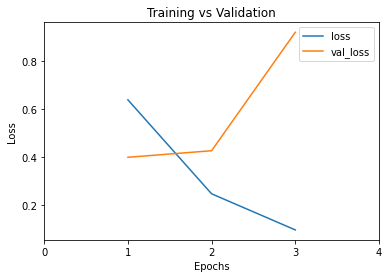

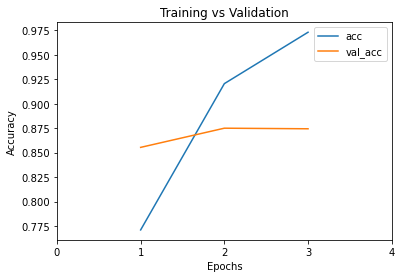

Training done in 9m 20s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2300    214
        -ve    414   2072
---------------------------------------------------
precision:0.8475, recall:0.9149
F1-score :0.8799
accuracy :0.8744
---------------------------------------------------
samples of predictions, outputs and true labels:
prediction:  tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
model output:  tensor([-38.3864,  -8.8538,   3.2233, -15.2193,   7.6280,  14.0923,  21.2828,
        -23.2004,   2.6235, -14.1570,  11.0211, -17.1806, -39.2121,  22.4724,
         35.7152,  15.6552,  22.5944,   2.7976, -17.5776,  22.8259],
       device='cuda:0')
true label:  tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1],
       device='cuda:0')


In [27]:
# LSTM

NUM_EPOCHS = 5


EMBED_SIZE = 256
HIDDEN_SIZE = 1024
n_layers = 1
bidirectional = True
dropout = 0.5
LR = 1e-3

CHECKPOINT_PATH = 'para/LSTM.pth'

model = LSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.7, 0.99))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
print('No of trainable parameters: ', para_num(model))

randomize()
history = train(model, train_dl, valid_dl, loss_fn, optimizer, NUM_EPOCHS, accuracy, device, CHECKPOINT_PATH, scheduler, binaryloss=True, early_stop=True)

confusion_m, acc, precision, recall = performance(model, valid_dl, binaryloss=True)
pred_all, out_all, label_all = predict(model, valid_dl, binaryloss=True, show_sample=20)

## Tuning Batch Size and Stopwords

In [28]:
stopwords_default = NLP.Defaults.stop_words
stopwords_add = NLP.Defaults.stop_words.union({'movie','film'})
stopwords_cut = NLP.Defaults.stop_words.difference({'nevertheless', 'however', 'although', 'up','down','no','not','nothing','n‘t',
 'n’t',"n't",'never','without','top','bottom','well','first','least'})


stop_list = [stopwords_default, stopwords_add, stopwords_cut, []]

para/stopwords-batch_0_8.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.8795 - acc: 0.7812 - val_loss: 0.6749 - val_acc: 0.8552
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.4249 - acc: 0.9176 - val_loss: 0.7529 - val_acc: 0.8776
Checkpoint Saved! Epoch 2 is better.***************************


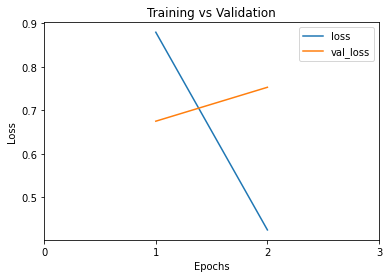

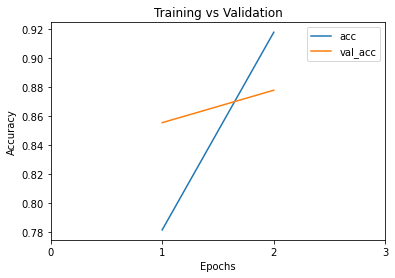

Training done in 10m 53s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2148    366
        -ve    246   2240
---------------------------------------------------
precision:0.8972, recall:0.8544
F1-score :0.8753
accuracy :0.8776
---------------------------------------------------
para/stopwords-batch_0_16.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 1.4045 - acc: 0.7560 - val_loss: 0.4181 - val_acc: 0.8672
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3132 - acc: 0.9111 - val_loss: 0.5721 - val_acc: 0.8668
early stop at epoch 2 *************************************


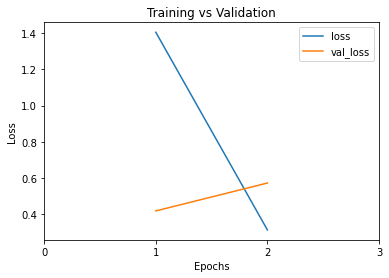

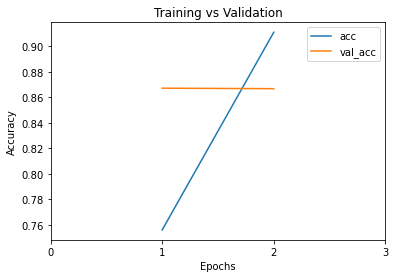

Training done in 7m 42s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2074    440
        -ve    227   2259
---------------------------------------------------
precision:0.9013, recall:0.8250
F1-score :0.8615
accuracy :0.8666
---------------------------------------------------
para/stopwords-batch_0_25.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.6483 - acc: 0.7716 - val_loss: 0.3912 - val_acc: 0.8578
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2419 - acc: 0.9198 - val_loss: 0.4588 - val_acc: 0.8712
Checkpoint Saved! Epoch 2 is better.***************************


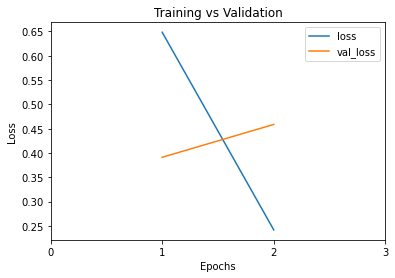

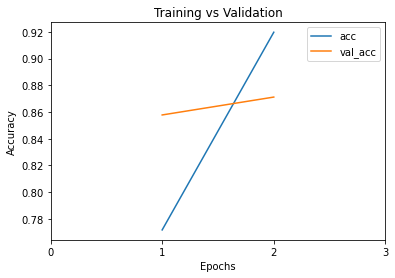

Training done in 6m 10s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2192    322
        -ve    322   2164
---------------------------------------------------
precision:0.8719, recall:0.8719
F1-score :0.8719
accuracy :0.8712
---------------------------------------------------
para/stopwords-batch_1_8.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.7824 - acc: 0.7812 - val_loss: 0.5857 - val_acc: 0.8558
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.4218 - acc: 0.9168 - val_loss: 0.8279 - val_acc: 0.8780
Checkpoint Saved! Epoch 2 is better.***************************


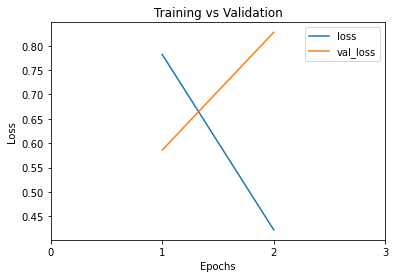

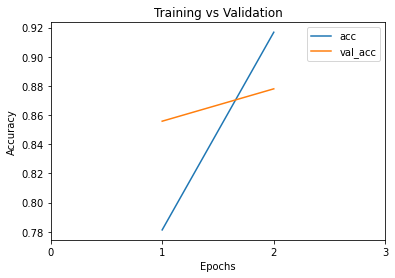

Training done in 10m 49s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2168    346
        -ve    264   2222
---------------------------------------------------
precision:0.8914, recall:0.8624
F1-score :0.8767
accuracy :0.8780
---------------------------------------------------
para/stopwords-batch_1_16.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.6324 - acc: 0.7804 - val_loss: 0.4601 - val_acc: 0.8488
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2795 - acc: 0.9193 - val_loss: 0.5865 - val_acc: 0.8734
Checkpoint Saved! Epoch 2 is better.***************************


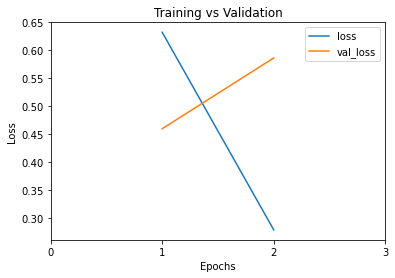

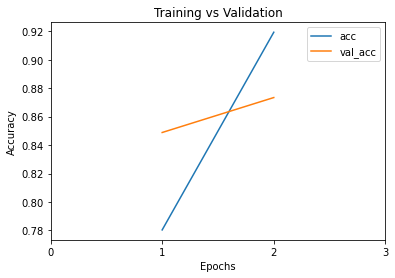

Training done in 7m 36s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2291    223
        -ve    411   2075
---------------------------------------------------
precision:0.8479, recall:0.9113
F1-score :0.8785
accuracy :0.8732
---------------------------------------------------
para/stopwords-batch_1_25.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.7363 - acc: 0.7699 - val_loss: 0.3758 - val_acc: 0.8568
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2456 - acc: 0.9200 - val_loss: 0.4511 - val_acc: 0.8730
Checkpoint Saved! Epoch 2 is better.***************************


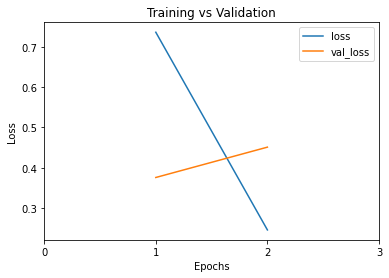

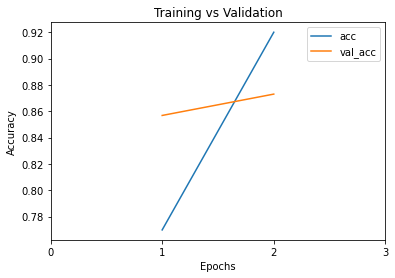

Training done in 6m 32s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2212    302
        -ve    333   2153
---------------------------------------------------
precision:0.8692, recall:0.8799
F1-score :0.8745
accuracy :0.8730
---------------------------------------------------
para/stopwords-batch_2_8.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.7801 - acc: 0.7832 - val_loss: 0.6724 - val_acc: 0.8516
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.4132 - acc: 0.9202 - val_loss: 0.8245 - val_acc: 0.8780
Checkpoint Saved! Epoch 2 is better.***************************


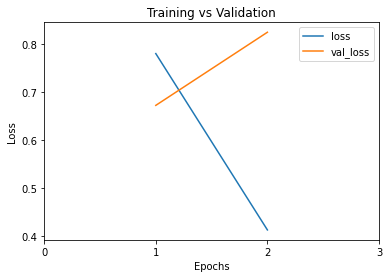

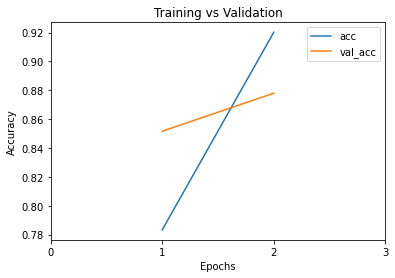

Training done in 10m 40s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2181    333
        -ve    277   2209
---------------------------------------------------
precision:0.8873, recall:0.8675
F1-score :0.8773
accuracy :0.8780
---------------------------------------------------
para/stopwords-batch_2_16.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.6413 - acc: 0.7823 - val_loss: 0.4128 - val_acc: 0.8512
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2889 - acc: 0.9196 - val_loss: 0.5755 - val_acc: 0.8760
Checkpoint Saved! Epoch 2 is better.***************************


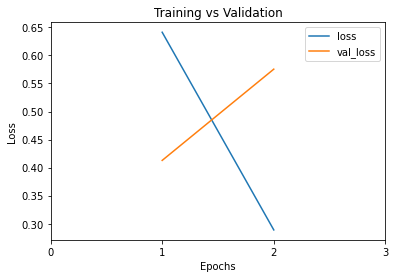

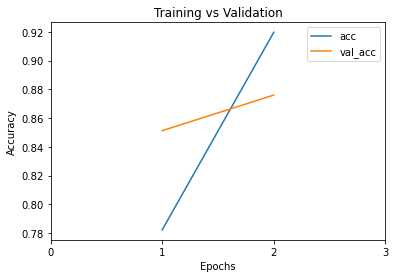

Training done in 7m 26s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2133    381
        -ve    239   2247
---------------------------------------------------
precision:0.8992, recall:0.8484
F1-score :0.8731
accuracy :0.8760
---------------------------------------------------
para/stopwords-batch_2_25.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.6400 - acc: 0.7740 - val_loss: 0.3727 - val_acc: 0.8606
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2471 - acc: 0.9192 - val_loss: 0.4947 - val_acc: 0.8702
Checkpoint Saved! Epoch 2 is better.***************************


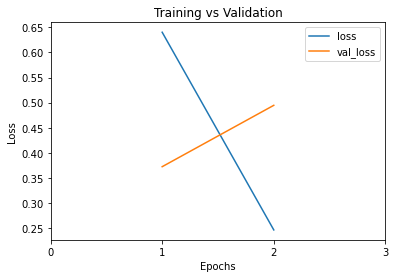

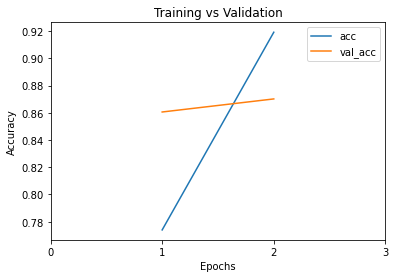

Training done in 6m 6s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2093    421
        -ve    228   2258
---------------------------------------------------
precision:0.9018, recall:0.8325
F1-score :0.8658
accuracy :0.8702
---------------------------------------------------
para/stopwords-batch_3_8.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 1.1457 - acc: 0.7500 - val_loss: 0.8968 - val_acc: 0.8318
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.5471 - acc: 0.9119 - val_loss: 1.1421 - val_acc: 0.8594
Checkpoint Saved! Epoch 2 is better.***************************


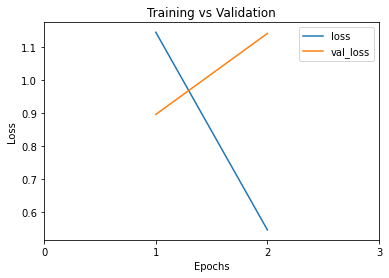

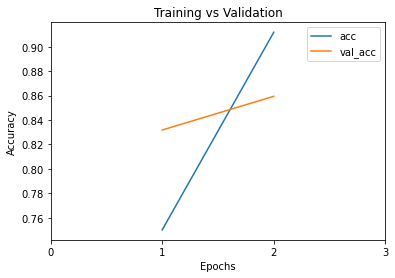

Training done in 10m 38s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2147    367
        -ve    336   2150
---------------------------------------------------
precision:0.8647, recall:0.8540
F1-score :0.8593
accuracy :0.8594
---------------------------------------------------
para/stopwords-batch_3_16.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.7457 - acc: 0.7557 - val_loss: 0.4861 - val_acc: 0.8431
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3011 - acc: 0.9181 - val_loss: 0.7402 - val_acc: 0.8446
Checkpoint Saved! Epoch 2 is better.***************************


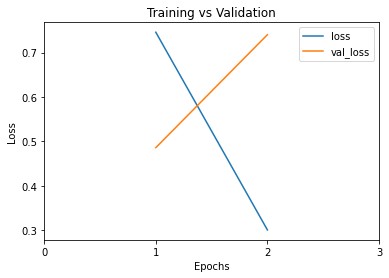

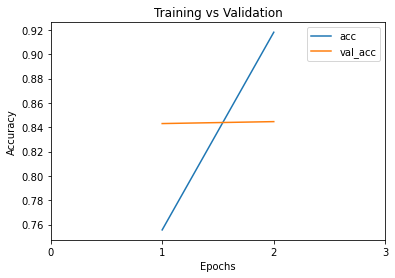

Training done in 7m 45s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1950    564
        -ve    213   2273
---------------------------------------------------
precision:0.9015, recall:0.7757
F1-score :0.8339
accuracy :0.8446
---------------------------------------------------
para/stopwords-batch_3_25.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.7199 - acc: 0.7443 - val_loss: 0.5072 - val_acc: 0.8246
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2507 - acc: 0.9218 - val_loss: 0.6121 - val_acc: 0.8556
Checkpoint Saved! Epoch 2 is better.***************************


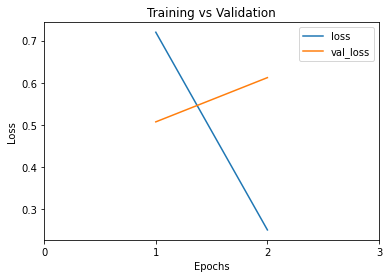

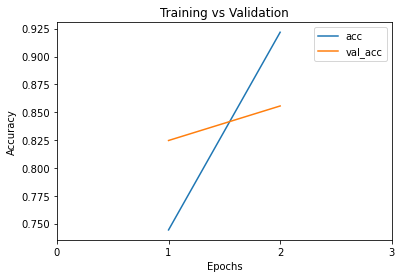

Training done in 6m 28s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2103    411
        -ve    311   2175
---------------------------------------------------
precision:0.8712, recall:0.8365
F1-score :0.8535
accuracy :0.8556
---------------------------------------------------
--------<<<-------best accuracy: 0.8780, best hyperparameters:1, 8 -------->>>--------


In [29]:
# Tune batch size and stopwords

NUM_EPOCHS = 2

batch_list = [8, 16, 25]

best_acc=0
all_acc = {}
for idx, stopwords in enumerate(stop_list):
    all_acc[idx]={}
    #set dataset
    train_ds = TextClassDataset(train_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
    valid_ds = TextClassDataset(valid_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
    test_ds = TextClassDataset(test_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
    
    for BATCH_SIZE in batch_list:
        #loader, vocab size 
        train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
        test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
        vocab = train_ds.vocab
        freqs = [(count, word) for (word, count) in vocab.word2count.items() if count >= MIN_COUNT]
        vocab_size = len(freqs) + 2  
        
        name_tuning = 'stopwords-batch'              #_____________change the experiment name to suit needs
        
        CHECKPOINT_PATH = 'para/'+name_tuning+'_'+str(idx)+'_'+str(BATCH_SIZE)+'.pth'                  #_____________change the variable name to suit needs
        print(CHECKPOINT_PATH,'-----------------------------------------------------------------')
        model = LSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)
        loss_fn = nn.BCEWithLogitsLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.7, 0.99))
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        print('No of trainable parameters: ', para_num(model))
        randomize()
        history = train(model, train_dl, valid_dl, loss_fn, optimizer, NUM_EPOCHS, accuracy, device, CHECKPOINT_PATH, scheduler, binaryloss=True, early_stop=True)
        confusion_m, acc, precision, recall = performance(model, valid_dl, binaryloss=True)
        if acc > best_acc:
            best_acc = acc
            best_hyper1 = idx                                                                            #_____________change the variable name to suit needs
            best_hyper2 = BATCH_SIZE
        all_acc[idx][BATCH_SIZE] = acc

print('--------<<<-------best accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [30]:
print('Accuracy  ',end='')
print('         default  add   cut  empty',end='')
for k in batch_list:
  print('')
  print('batch size='+str(k)+'      ', end='')
  for idx in [0,1,2,3]:
    print("{:.2f}".format(all_acc[idx][k]*100)+'% ', end='')

Accuracy           default  add   cut  empty
batch size=8      87.76% 87.80% 87.80% 85.94% 
batch size=16      86.66% 87.32% 87.60% 84.46% 
batch size=25      87.12% 87.30% 87.02% 85.56% 

## Dataset Config

Instead of choosing hyperparameters with highest accuracy, we will choose batch size 16 and the cut version of stopwords, as the best one is only 0.2% higher in accuracy but the computation time is 50% more.

Let's confirm the dataset after we decide the batch size and stopwords.

In [31]:
# set dataset, loader and vocab size with best hyperparameters
stopwords = stopwords_cut
BATCH_SIZE = 16

train_ds = TextClassDataset(train_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
valid_ds = TextClassDataset(valid_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
test_ds = TextClassDataset(test_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
vocab = train_ds.vocab
freqs = [(count, word) for (word, count) in vocab.word2count.items() if count >= MIN_COUNT]
vocab_size = len(freqs) + 2  

## Tuning - Helper functions

In [32]:
def tune_one(model, best_acc, best_hyper1, best_hyper2):
        CHECKPOINT_PATH = 'para/'+name_tuning+'_'+str(i)+'_'+str(j)+'.pth'
        print(CHECKPOINT_PATH,'-----------------------------------------------------------------')
        loss_fn = nn.BCEWithLogitsLoss().to(device)   #####  Diff from attention model
        optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.7, 0.99))
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        print('No of trainable parameters: ', para_num(model))
        randomize()
        history = train(model, train_dl, valid_dl, loss_fn, optimizer, NUM_EPOCHS, accuracy, device, CHECKPOINT_PATH, scheduler, binaryloss=True, early_stop=True)
        confusion_m, acc, precision, recall = performance(model, valid_dl, binaryloss=True)
        if acc > best_acc:
            best_acc = acc
            best_hyper1 = i
            best_hyper2 = j
        return best_acc, best_hyper1, best_hyper2, acc

## Tuning - Common Config

In [33]:
# set common variables/config for tuning

model_trial={}
NUM_EPOCHS = 2

## Tuning LSTM 

para/l-dropout-lr_0.25_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.6146 - acc: 0.7941 - val_loss: 0.3446 - val_acc: 0.8692
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2195 - acc: 0.9353 - val_loss: 0.5156 - val_acc: 0.8756
Checkpoint Saved! Epoch 2 is better.***************************


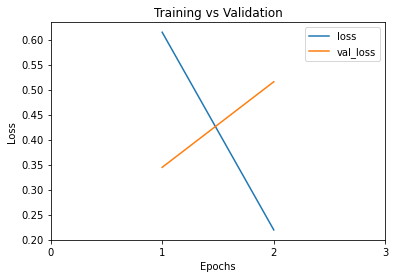

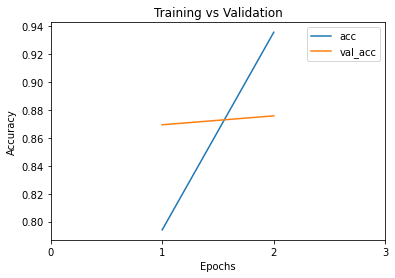

Training done in 7m 55s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2142    372
        -ve    251   2235
---------------------------------------------------
precision:0.8951, recall:0.8520
F1-score :0.8730
accuracy :0.8754
---------------------------------------------------
para/l-dropout-lr_0.25_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.4982 - acc: 0.7820 - val_loss: 0.4461 - val_acc: 0.8213
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2141 - acc: 0.9208 - val_loss: 0.4755 - val_acc: 0.8576
Checkpoint Saved! Epoch 2 is better.***************************


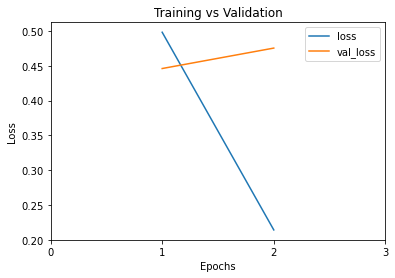

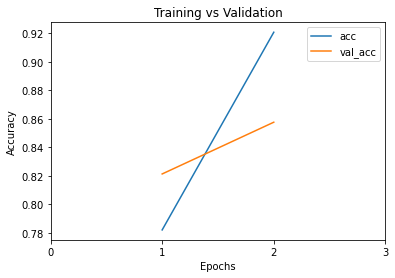

Training done in 7m 31s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2084    430
        -ve    282   2204
---------------------------------------------------
precision:0.8808, recall:0.8290
F1-score :0.8541
accuracy :0.8576
---------------------------------------------------
para/l-dropout-lr_0.25_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.4927 - acc: 0.7631 - val_loss: 0.4492 - val_acc: 0.7993
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2685 - acc: 0.8879 - val_loss: 0.3770 - val_acc: 0.8526
Checkpoint Saved! Epoch 2 is better.***************************


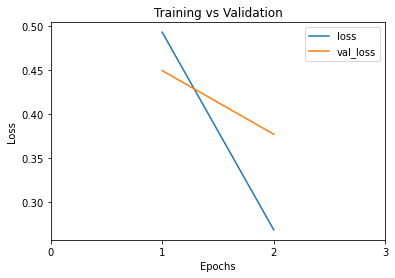

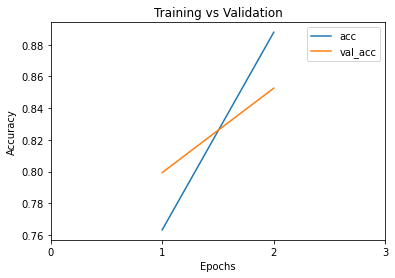

Training done in 7m 19s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2089    425
        -ve    313   2173
---------------------------------------------------
precision:0.8697, recall:0.8309
F1-score :0.8499
accuracy :0.8524
---------------------------------------------------
para/l-dropout-lr_0.5_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.6413 - acc: 0.7823 - val_loss: 0.4128 - val_acc: 0.8512
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2889 - acc: 0.9196 - val_loss: 0.5755 - val_acc: 0.8760
Checkpoint Saved! Epoch 2 is better.***************************


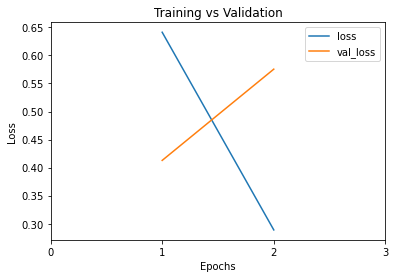

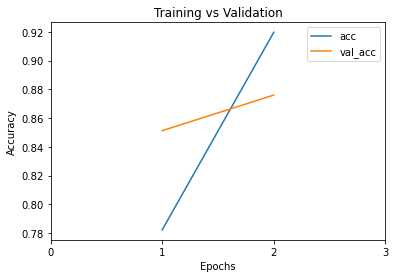

Training done in 7m 24s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2133    381
        -ve    239   2247
---------------------------------------------------
precision:0.8992, recall:0.8484
F1-score :0.8731
accuracy :0.8760
---------------------------------------------------
para/l-dropout-lr_0.5_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.5066 - acc: 0.7763 - val_loss: 0.4685 - val_acc: 0.8191
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2282 - acc: 0.9155 - val_loss: 0.5055 - val_acc: 0.8540
Checkpoint Saved! Epoch 2 is better.***************************


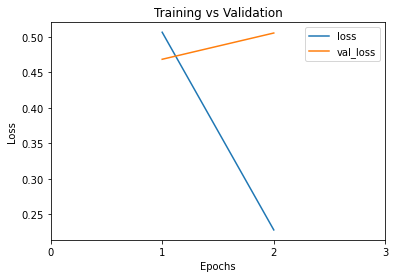

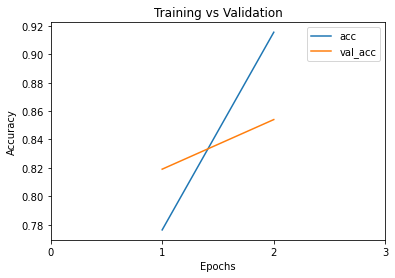

Training done in 7m 16s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2025    489
        -ve    241   2245
---------------------------------------------------
precision:0.8936, recall:0.8055
F1-score :0.8473
accuracy :0.8540
---------------------------------------------------
para/l-dropout-lr_0.5_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.4988 - acc: 0.7573 - val_loss: 0.4550 - val_acc: 0.7975
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2846 - acc: 0.8819 - val_loss: 0.3700 - val_acc: 0.8542
Checkpoint Saved! Epoch 2 is better.***************************


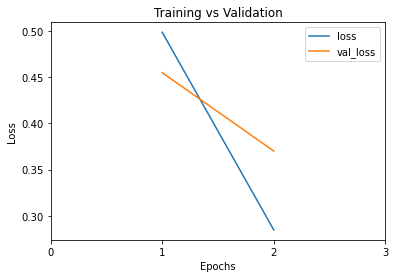

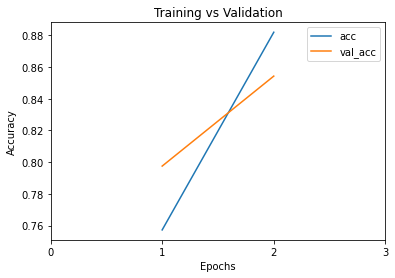

Training done in 7m 39s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2094    420
        -ve    310   2176
---------------------------------------------------
precision:0.8710, recall:0.8329
F1-score :0.8516
accuracy :0.8540
---------------------------------------------------
para/l-dropout-lr_0.6_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.6828 - acc: 0.7736 - val_loss: 0.4047 - val_acc: 0.8624
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3167 - acc: 0.9136 - val_loss: 0.5306 - val_acc: 0.8844
Checkpoint Saved! Epoch 2 is better.***************************


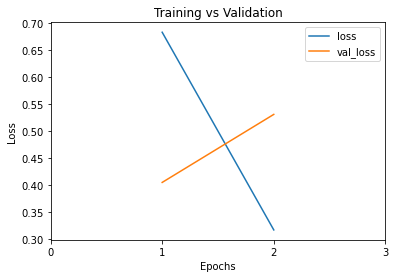

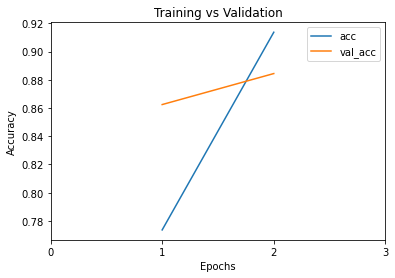

Training done in 7m 41s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2263    251
        -ve    327   2159
---------------------------------------------------
precision:0.8737, recall:0.9002
F1-score :0.8868
accuracy :0.8844
---------------------------------------------------
para/l-dropout-lr_0.6_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.5128 - acc: 0.7734 - val_loss: 0.4578 - val_acc: 0.8237
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2431 - acc: 0.9111 - val_loss: 0.4632 - val_acc: 0.8626
Checkpoint Saved! Epoch 2 is better.***************************


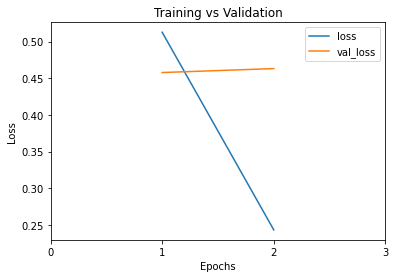

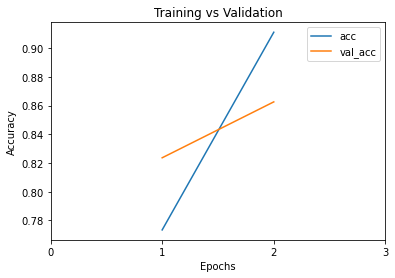

Training done in 7m 19s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2081    433
        -ve    255   2231
---------------------------------------------------
precision:0.8908, recall:0.8278
F1-score :0.8581
accuracy :0.8624
---------------------------------------------------
para/l-dropout-lr_0.6_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.5023 - acc: 0.7541 - val_loss: 0.4620 - val_acc: 0.7945
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2927 - acc: 0.8787 - val_loss: 0.3610 - val_acc: 0.8548
Checkpoint Saved! Epoch 2 is better.***************************


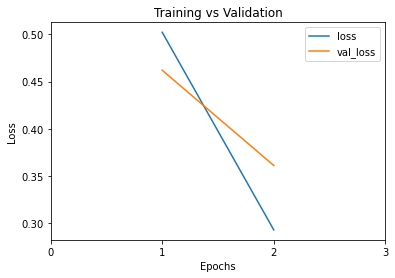

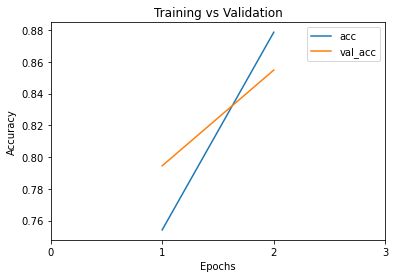

Training done in 7m 24s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2121    393
        -ve    334   2152
---------------------------------------------------
precision:0.8640, recall:0.8437
F1-score :0.8537
accuracy :0.8546
---------------------------------------------------
--------<<<-------best validation accuracy: 0.8844, best hyperparameters:0.6, 0.001 -------->>>--------


In [34]:
# LSTM tuning 1

name_tuning = 'l-dropout-lr'

EMBED_SIZE = 256
HIDDEN_SIZE = 1024
n_layers = 1
bidirectional = True

list1 = [0.25, 0.5, 0.6]                  #change search space to suit needs----------------------<<<
list2 = [1e-3, 3e-4, 1e-4]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        dropout, LR = i, j                                                                        #change variable names----------------------<<<
        model = LSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)            #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [35]:
print('Accuracy    ',end='')
for j in list2:
    print(' lr={}'.format(j),end='')
    
for i in list1:
    print('')
    print('dropout='+str(i)+'  ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'%   ', end='')

Accuracy     lr=0.001 lr=0.0003 lr=0.0001
dropout=0.25  87.54%   85.76%   85.24%   
dropout=0.5  87.60%   85.40%   85.40%   
dropout=0.6  88.44%   86.24%   85.46%   

In [36]:
best_l={}
best_l['dropout']=best_hyper1
best_l['LR']=best_hyper2

para/l-embed-hidden_128_512.pth -----------------------------------------------------------------
No of trainable parameters:  6060801
Epoch [1/2], loss: 0.5825 - acc: 0.7670 - val_loss: 0.4366 - val_acc: 0.8401
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2898 - acc: 0.9056 - val_loss: 0.4279 - val_acc: 0.8830
Checkpoint Saved! Epoch 2 is better.***************************


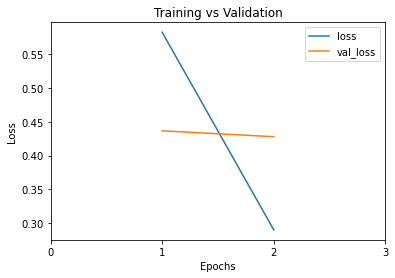

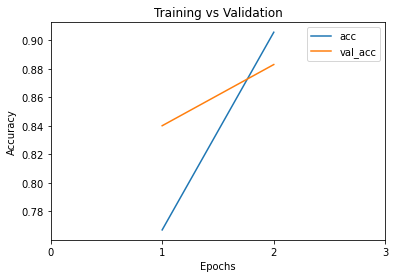

Training done in 6m 13s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2295    219
        -ve    366   2120
---------------------------------------------------
precision:0.8625, recall:0.9129
F1-score :0.8870
accuracy :0.8830
---------------------------------------------------
para/l-embed-hidden_128_1024.pth -----------------------------------------------------------------
No of trainable parameters:  13089537
Epoch [1/2], loss: 0.6373 - acc: 0.7528 - val_loss: 0.4055 - val_acc: 0.8429
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3080 - acc: 0.9012 - val_loss: 0.4091 - val_acc: 0.8790
Checkpoint Saved! Epoch 2 is better.***************************


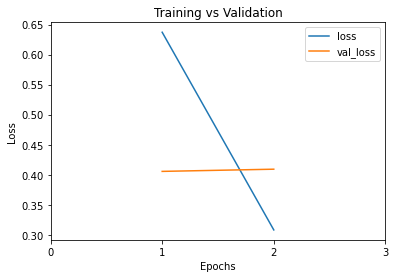

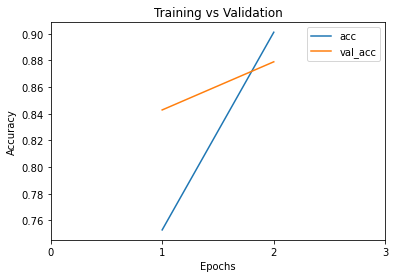

Training done in 7m 17s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2287    227
        -ve    378   2108
---------------------------------------------------
precision:0.8582, recall:0.9097
F1-score :0.8832
accuracy :0.8790
---------------------------------------------------
para/l-embed-hidden_128_2048.pth -----------------------------------------------------------------
No of trainable parameters:  39729921
Epoch [1/2], loss: 1.4735 - acc: 0.6515 - val_loss: 0.4353 - val_acc: 0.8291
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3850 - acc: 0.8640 - val_loss: 0.3717 - val_acc: 0.8608
Checkpoint Saved! Epoch 2 is better.***************************


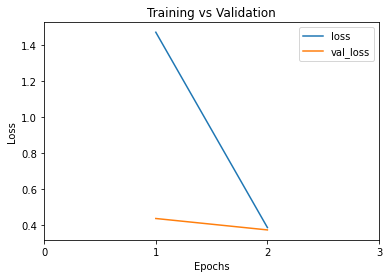

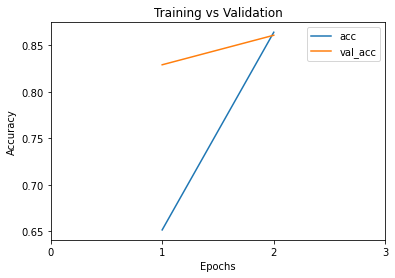

Training done in 11m 13s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2175    339
        -ve    357   2129
---------------------------------------------------
precision:0.8590, recall:0.8652
F1-score :0.8621
accuracy :0.8608
---------------------------------------------------
para/l-embed-hidden_256_512.pth -----------------------------------------------------------------
No of trainable parameters:  9811457
Epoch [1/2], loss: 0.6555 - acc: 0.7801 - val_loss: 0.4635 - val_acc: 0.8560
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3190 - acc: 0.9154 - val_loss: 0.5698 - val_acc: 0.8792
Checkpoint Saved! Epoch 2 is better.***************************


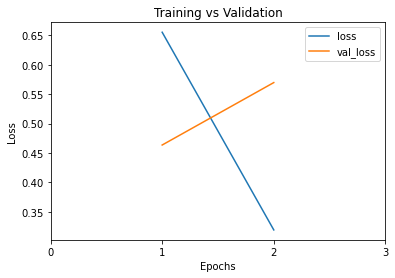

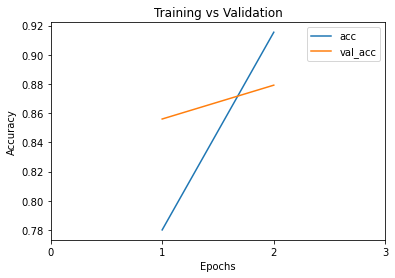

Training done in 6m 15s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2202    312
        -ve    293   2193
---------------------------------------------------
precision:0.8826, recall:0.8759
F1-score :0.8792
accuracy :0.8790
---------------------------------------------------
para/l-embed-hidden_256_1024.pth -----------------------------------------------------------------
No of trainable parameters:  17364481
Epoch [1/2], loss: 0.6828 - acc: 0.7736 - val_loss: 0.4047 - val_acc: 0.8624
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3167 - acc: 0.9136 - val_loss: 0.5306 - val_acc: 0.8844
Checkpoint Saved! Epoch 2 is better.***************************


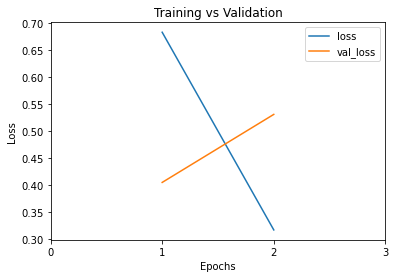

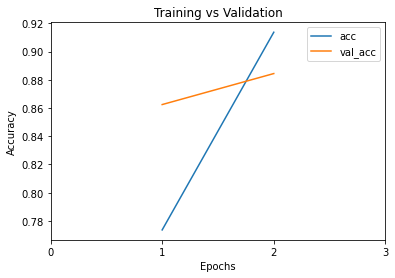

Training done in 7m 28s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2263    251
        -ve    327   2159
---------------------------------------------------
precision:0.8737, recall:0.9002
F1-score :0.8868
accuracy :0.8844
---------------------------------------------------
para/l-embed-hidden_256_2048.pth -----------------------------------------------------------------
No of trainable parameters:  45053441
Epoch [1/2], loss: 0.8824 - acc: 0.7517 - val_loss: 0.5871 - val_acc: 0.8429
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.4515 - acc: 0.8990 - val_loss: 0.6689 - val_acc: 0.8704
Checkpoint Saved! Epoch 2 is better.***************************


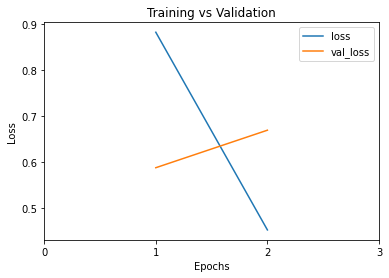

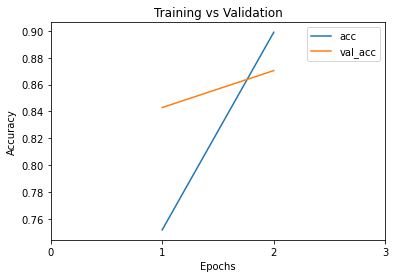

Training done in 11m 34s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2116    398
        -ve    251   2235
---------------------------------------------------
precision:0.8940, recall:0.8417
F1-score :0.8670
accuracy :0.8702
---------------------------------------------------
para/l-embed-hidden_512_512.pth -----------------------------------------------------------------
No of trainable parameters:  17312769
Epoch [1/2], loss: 0.8150 - acc: 0.7854 - val_loss: 0.6447 - val_acc: 0.8648
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.4161 - acc: 0.9240 - val_loss: 0.9164 - val_acc: 0.8710
Checkpoint Saved! Epoch 2 is better.***************************


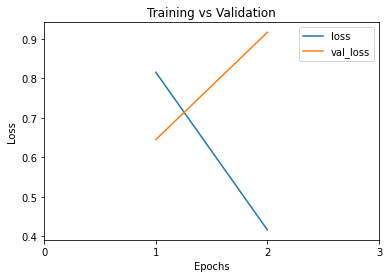

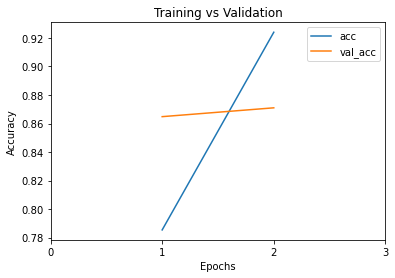

Training done in 6m 12s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2183    331
        -ve    315   2171
---------------------------------------------------
precision:0.8739, recall:0.8683
F1-score :0.8711
accuracy :0.8708
---------------------------------------------------
para/l-embed-hidden_512_1024.pth -----------------------------------------------------------------
No of trainable parameters:  25914369
Epoch [1/2], loss: 1.0028 - acc: 0.7771 - val_loss: 0.8624 - val_acc: 0.8460
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.4768 - acc: 0.9172 - val_loss: 0.9104 - val_acc: 0.8746
Checkpoint Saved! Epoch 2 is better.***************************


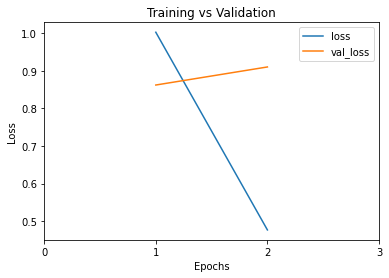

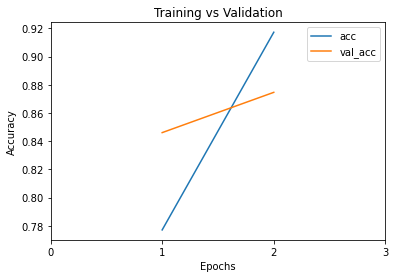

Training done in 7m 23s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2263    251
        -ve    377   2109
---------------------------------------------------
precision:0.8572, recall:0.9002
F1-score :0.8782
accuracy :0.8744
---------------------------------------------------
para/l-embed-hidden_512_2048.pth -----------------------------------------------------------------
No of trainable parameters:  55700481
Epoch [1/2], loss: 1.1310 - acc: 0.7636 - val_loss: 0.7262 - val_acc: 0.8518
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.5740 - acc: 0.9041 - val_loss: 0.9976 - val_acc: 0.8626
Checkpoint Saved! Epoch 2 is better.***************************


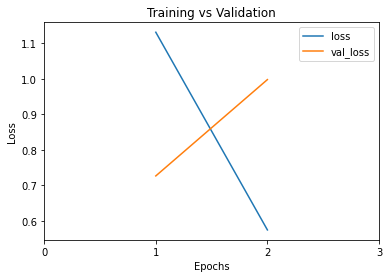

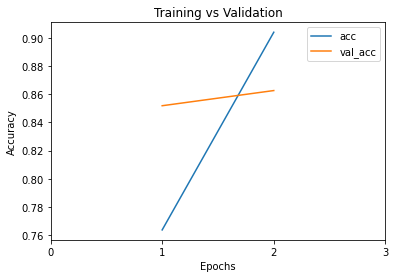

Training done in 11m 44s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2049    465
        -ve    221   2265
---------------------------------------------------
precision:0.9026, recall:0.8150
F1-score :0.8566
accuracy :0.8628
---------------------------------------------------
--------<<<-------best validation accuracy: 0.8844, best hyperparameters:256, 1024 -------->>>--------


In [37]:
# LSTM tuning 2

name_tuning = 'l-embed-hidden'

n_layers = 1
bidirectional = True
dropout = best_hyper1
LR = best_hyper2

list1 = [128, 256, 512]                  #change search space to suit needs----------------------<<<
list2 = [512, 1024, 2048]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        EMBED_SIZE, HIDDEN_SIZE = i, j                                                                        #change variable names----------------------<<<
        model = LSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)            #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [38]:
print('Accuracy',end='')
for j in list2:
    print('  hidden={}'.format(j),end='')
    
for i in list1:
    print('')
    print('embed='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'%      ', end='')

Accuracy  hidden=512  hidden=1024  hidden=2048
embed=128      88.30%      87.90%      86.08%      
embed=256      87.90%      88.44%      87.02%      
embed=512      87.08%      87.44%      86.28%      

In [39]:
best_l['EMBED_SIZE'] = best_hyper1
best_l['HIDDEN_SIZE'] = best_hyper2

## Tuning GRU

para/g-dropout-lr_0.25_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  14738945
Epoch [1/2], loss: 3.3456 - acc: 0.7349 - val_loss: 2.9620 - val_acc: 0.8199
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 2.4183 - acc: 0.8744 - val_loss: 3.6996 - val_acc: 0.8490
Checkpoint Saved! Epoch 2 is better.***************************


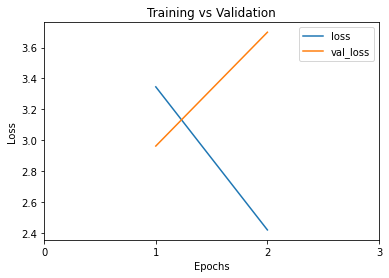

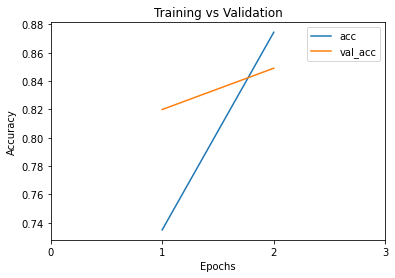

Training done in 6m 49s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2076    438
        -ve    317   2169
---------------------------------------------------
precision:0.8675, recall:0.8258
F1-score :0.8461
accuracy :0.8490
---------------------------------------------------
para/g-dropout-lr_0.25_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  14738945
Epoch [1/2], loss: 0.9415 - acc: 0.7119 - val_loss: 1.1331 - val_acc: 0.7540
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.5116 - acc: 0.8665 - val_loss: 0.7505 - val_acc: 0.8221
Checkpoint Saved! Epoch 2 is better.***************************


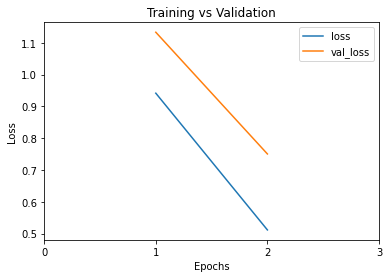

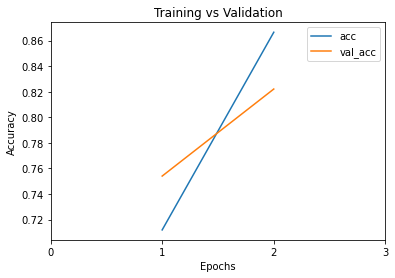

Training done in 6m 52s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1929    585
        -ve    305   2181
---------------------------------------------------
precision:0.8635, recall:0.7673
F1-score :0.8126
accuracy :0.8220
---------------------------------------------------
para/g-dropout-lr_0.25_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  14738945
Epoch [1/2], loss: 0.5616 - acc: 0.7289 - val_loss: 0.4828 - val_acc: 0.7885
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3129 - acc: 0.8703 - val_loss: 0.4443 - val_acc: 0.8227
Checkpoint Saved! Epoch 2 is better.***************************


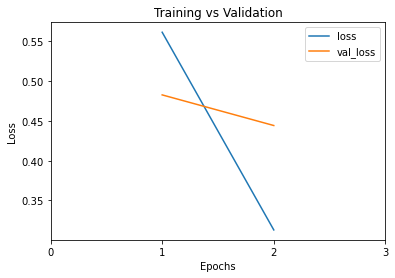

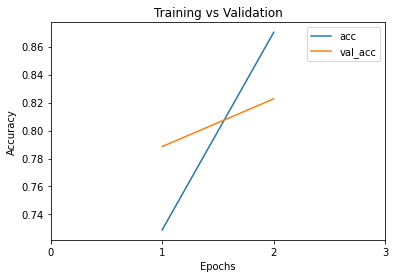

Training done in 6m 53s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2149    365
        -ve    523   1963
---------------------------------------------------
precision:0.8043, recall:0.8548
F1-score :0.8288
accuracy :0.8224
---------------------------------------------------
para/g-dropout-lr_0.5_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  14738945
Epoch [1/2], loss: 4.7096 - acc: 0.7279 - val_loss: 3.0042 - val_acc: 0.8253
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 3.0012 - acc: 0.8679 - val_loss: 3.7450 - val_acc: 0.8568
Checkpoint Saved! Epoch 2 is better.***************************


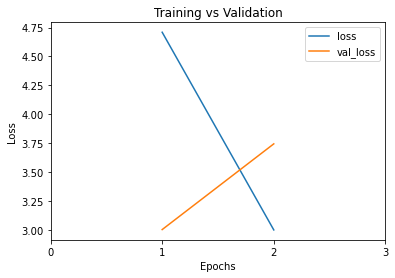

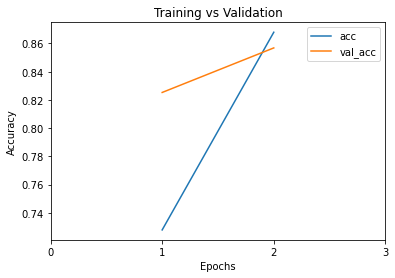

Training done in 6m 56s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2127    387
        -ve    330   2156
---------------------------------------------------
precision:0.8657, recall:0.8461
F1-score :0.8558
accuracy :0.8566
---------------------------------------------------
para/g-dropout-lr_0.5_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  14738945
Epoch [1/2], loss: 1.1335 - acc: 0.6987 - val_loss: 1.6220 - val_acc: 0.7402
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.6793 - acc: 0.8517 - val_loss: 0.8143 - val_acc: 0.8397
Checkpoint Saved! Epoch 2 is better.***************************


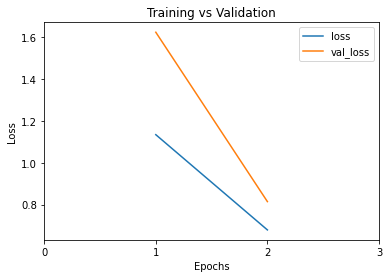

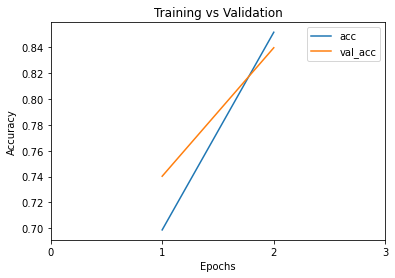

Training done in 6m 40s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2271    243
        -ve    560   1926
---------------------------------------------------
precision:0.8022, recall:0.9033
F1-score :0.8498
accuracy :0.8394
---------------------------------------------------
para/g-dropout-lr_0.5_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  14738945
Epoch [1/2], loss: 0.5881 - acc: 0.7158 - val_loss: 0.5237 - val_acc: 0.7776
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3650 - acc: 0.8517 - val_loss: 0.5298 - val_acc: 0.8007
Checkpoint Saved! Epoch 2 is better.***************************


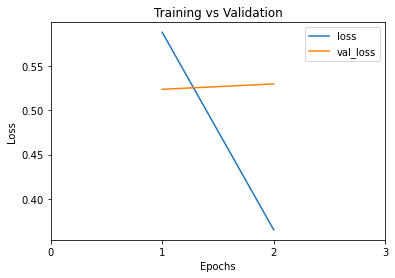

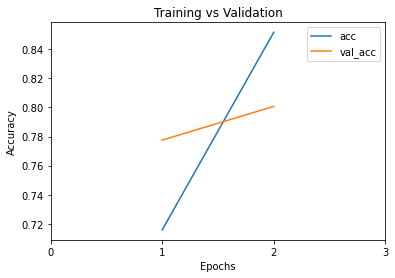

Training done in 6m 47s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2347    167
        -ve    830   1656
---------------------------------------------------
precision:0.7387, recall:0.9336
F1-score :0.8248
accuracy :0.8006
---------------------------------------------------
para/g-dropout-lr_0.6_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  14738945
Epoch [1/2], loss: 4.9792 - acc: 0.7231 - val_loss: 4.5579 - val_acc: 0.8079
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 3.4617 - acc: 0.8653 - val_loss: 4.1180 - val_acc: 0.8528
Checkpoint Saved! Epoch 2 is better.***************************


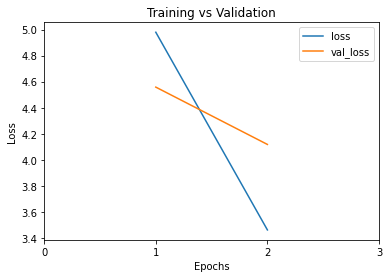

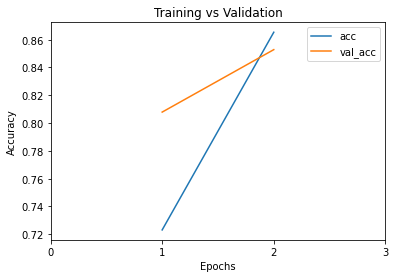

Training done in 6m 49s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2189    325
        -ve    412   2074
---------------------------------------------------
precision:0.8416, recall:0.8707
F1-score :0.8559
accuracy :0.8526
---------------------------------------------------
para/g-dropout-lr_0.6_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  14738945
Epoch [1/2], loss: 1.2938 - acc: 0.6904 - val_loss: 1.8956 - val_acc: 0.7238
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.8504 - acc: 0.8369 - val_loss: 1.1258 - val_acc: 0.8185
Checkpoint Saved! Epoch 2 is better.***************************


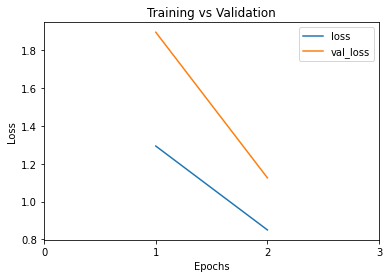

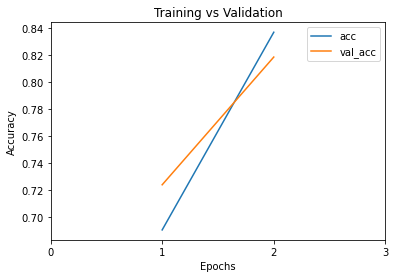

Training done in 6m 34s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2402    112
        -ve    797   1689
---------------------------------------------------
precision:0.7509, recall:0.9554
F1-score :0.8409
accuracy :0.8182
---------------------------------------------------
para/g-dropout-lr_0.6_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  14738945
Epoch [1/2], loss: 0.6117 - acc: 0.7081 - val_loss: 0.5700 - val_acc: 0.7546
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3997 - acc: 0.8383 - val_loss: 0.5575 - val_acc: 0.8001
Checkpoint Saved! Epoch 2 is better.***************************


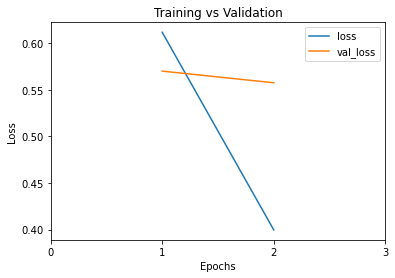

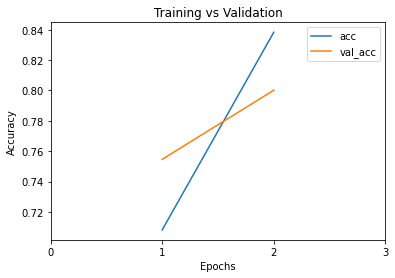

Training done in 6m 40s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2343    171
        -ve    829   1657
---------------------------------------------------
precision:0.7387, recall:0.9320
F1-score :0.8241
accuracy :0.8000
---------------------------------------------------
--------<<<-------best validation accuracy: 0.8566, best hyperparameters:0.5, 0.001 -------->>>--------


In [40]:
# GRU tuning 1

name_tuning = 'g-dropout-lr'

EMBED_SIZE = 256
HIDDEN_SIZE = 1024
n_layers = 1
bidirectional = True

list1 = [0.25, 0.5, 0.6]                  #change search space to suit needs----------------------<<<
list2 = [1e-3, 3e-4, 1e-4]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        dropout, LR = i, j                                                                        #change variable names----------------------<<<
        model = GRU(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)            #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [41]:
print('Accuracy    ',end='')
for j in list2:
    print(' lr={}'.format(j),end='')
    
for i in list1:
    print('')
    print('dropout='+str(i)+'  ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'%   ', end='')

Accuracy     lr=0.001 lr=0.0003 lr=0.0001
dropout=0.25  84.90%   82.20%   82.24%   
dropout=0.5  85.66%   83.94%   80.06%   
dropout=0.6  85.26%   81.82%   80.00%   

In [42]:
best_g={}
best_g['dropout']=best_hyper1
best_g['LR']=best_hyper2

para/g-embed-hidden_128_512.pth -----------------------------------------------------------------
No of trainable parameters:  5403393
Epoch [1/2], loss: 1.9946 - acc: 0.7015 - val_loss: 1.8817 - val_acc: 0.7941
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 1.1617 - acc: 0.8555 - val_loss: 1.4065 - val_acc: 0.8395
Checkpoint Saved! Epoch 2 is better.***************************


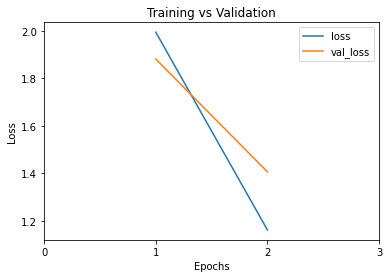

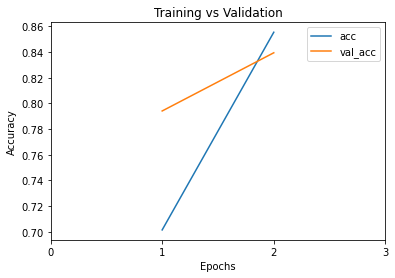

Training done in 5m 55s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1969    545
        -ve    259   2227
---------------------------------------------------
precision:0.8838, recall:0.7832
F1-score :0.8305
accuracy :0.8392
---------------------------------------------------
para/g-embed-hidden_128_1024.pth -----------------------------------------------------------------
No of trainable parameters:  10726145
Epoch [1/2], loss: 3.5634 - acc: 0.6838 - val_loss: 3.8420 - val_acc: 0.7722
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 2.2738 - acc: 0.8429 - val_loss: 2.2130 - val_acc: 0.8446
Checkpoint Saved! Epoch 2 is better.***************************


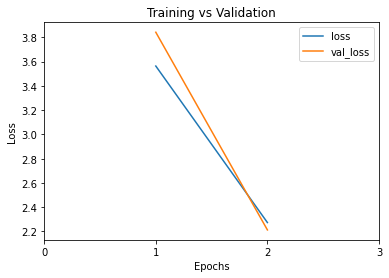

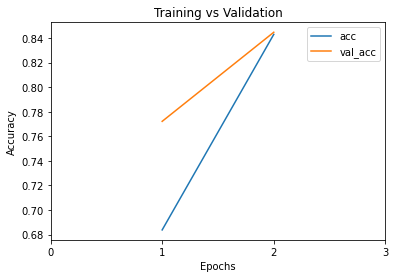

Training done in 6m 41s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2164    350
        -ve    427   2059
---------------------------------------------------
precision:0.8352, recall:0.8608
F1-score :0.8478
accuracy :0.8446
---------------------------------------------------
para/g-embed-hidden_128_2048.pth -----------------------------------------------------------------
No of trainable parameters:  30808833
Epoch [1/2], loss: 6.1458 - acc: 0.6619 - val_loss: 5.4452 - val_acc: 0.7672
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 5.8102 - acc: 0.8015 - val_loss: 5.9175 - val_acc: 0.7943
Checkpoint Saved! Epoch 2 is better.***************************


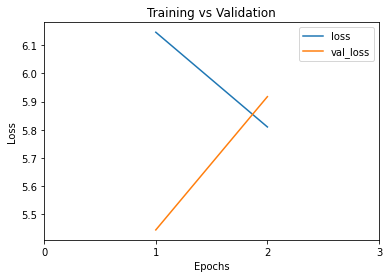

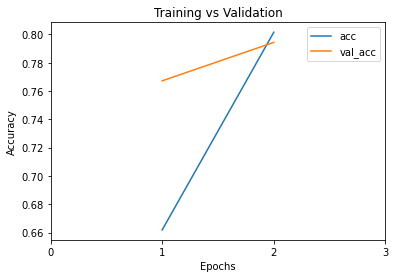

Training done in 9m 52s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1766    748
        -ve    280   2206
---------------------------------------------------
precision:0.8631, recall:0.7025
F1-score :0.7746
accuracy :0.7944
---------------------------------------------------
para/g-embed-hidden_256_512.pth -----------------------------------------------------------------
No of trainable parameters:  9022977
Epoch [1/2], loss: 1.7561 - acc: 0.7467 - val_loss: 1.7555 - val_acc: 0.8257
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 1.2589 - acc: 0.8797 - val_loss: 1.7915 - val_acc: 0.8520
Checkpoint Saved! Epoch 2 is better.***************************


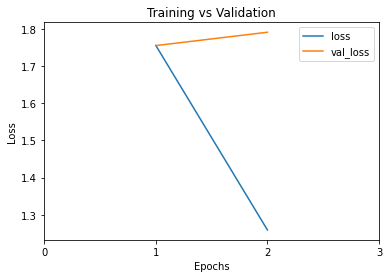

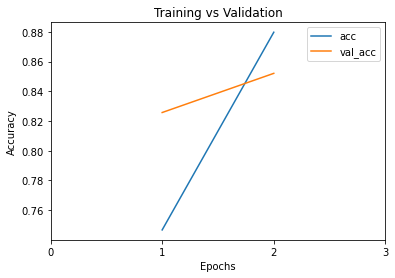

Training done in 6m 32s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2080    434
        -ve    307   2179
---------------------------------------------------
precision:0.8714, recall:0.8274
F1-score :0.8488
accuracy :0.8518
---------------------------------------------------
para/g-embed-hidden_256_1024.pth -----------------------------------------------------------------
No of trainable parameters:  14738945
Epoch [1/2], loss: 4.7096 - acc: 0.7279 - val_loss: 3.0042 - val_acc: 0.8253
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 3.0012 - acc: 0.8679 - val_loss: 3.7450 - val_acc: 0.8568
Checkpoint Saved! Epoch 2 is better.***************************


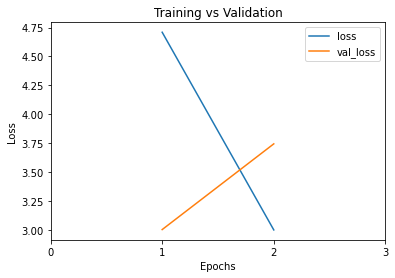

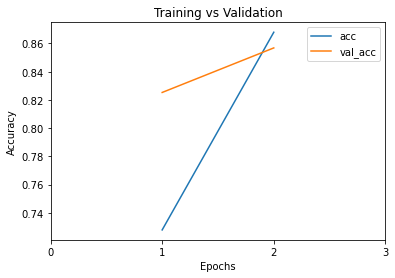

Training done in 8m 2s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2127    387
        -ve    330   2156
---------------------------------------------------
precision:0.8657, recall:0.8461
F1-score :0.8558
accuracy :0.8566
---------------------------------------------------
para/g-embed-hidden_256_2048.pth -----------------------------------------------------------------
No of trainable parameters:  35608065
Epoch [1/2], loss: 14.4851 - acc: 0.6478 - val_loss: 38.6954 - val_acc: 0.5849
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 10.3514 - acc: 0.8106 - val_loss: 8.5692 - val_acc: 0.8385
Checkpoint Saved! Epoch 2 is better.***************************


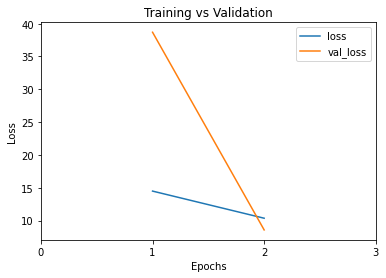

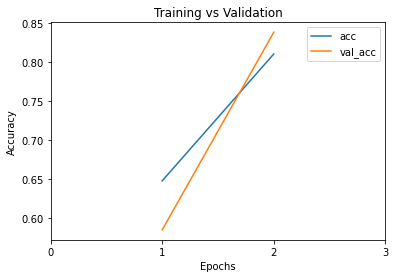

Training done in 10m 51s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2040    474
        -ve    333   2153
---------------------------------------------------
precision:0.8597, recall:0.8115
F1-score :0.8349
accuracy :0.8386
---------------------------------------------------
para/g-embed-hidden_512_512.pth -----------------------------------------------------------------
No of trainable parameters:  16262145
Epoch [1/2], loss: 2.1487 - acc: 0.7675 - val_loss: 2.7207 - val_acc: 0.8129
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 1.5436 - acc: 0.8973 - val_loss: 2.9840 - val_acc: 0.8584
Checkpoint Saved! Epoch 2 is better.***************************


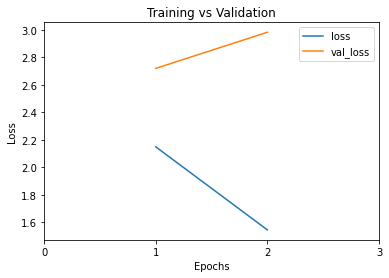

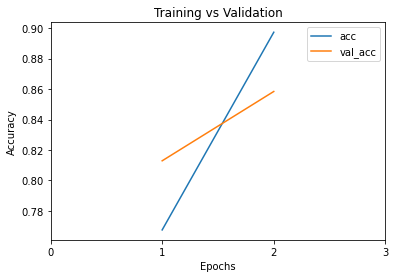

Training done in 7m 8s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2236    278
        -ve    431   2055
---------------------------------------------------
precision:0.8384, recall:0.8894
F1-score :0.8632
accuracy :0.8582
---------------------------------------------------
para/g-embed-hidden_512_1024.pth -----------------------------------------------------------------
No of trainable parameters:  22764545
Epoch [1/2], loss: 4.3062 - acc: 0.7592 - val_loss: 4.1332 - val_acc: 0.8496
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 3.1849 - acc: 0.8883 - val_loss: 5.0469 - val_acc: 0.8470
early stop at epoch 2 *************************************


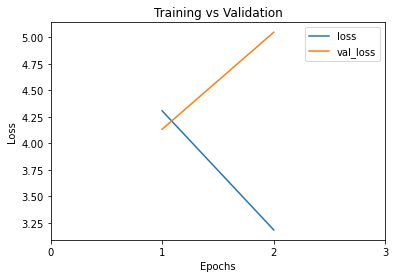

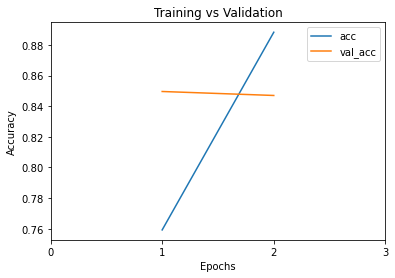

Training done in 6m 40s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1982    532
        -ve    233   2253
---------------------------------------------------
precision:0.8948, recall:0.7884
F1-score :0.8382
accuracy :0.8470
---------------------------------------------------
para/g-embed-hidden_512_2048.pth -----------------------------------------------------------------
No of trainable parameters:  45206529
Epoch [1/2], loss: 13.6395 - acc: 0.7205 - val_loss: 27.2258 - val_acc: 0.7141
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 11.3042 - acc: 0.8416 - val_loss: 11.4446 - val_acc: 0.8395
Checkpoint Saved! Epoch 2 is better.***************************


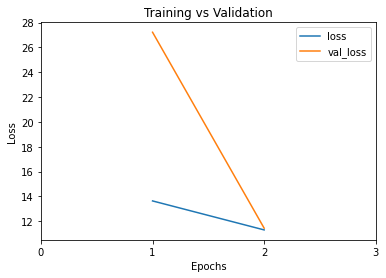

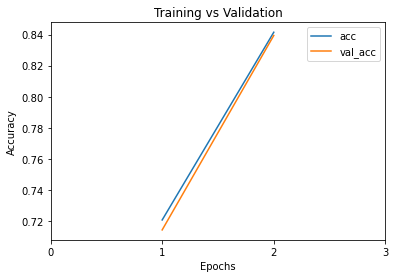

Training done in 10m 5s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2108    406
        -ve    397   2089
---------------------------------------------------
precision:0.8415, recall:0.8385
F1-score :0.8400
accuracy :0.8394
---------------------------------------------------
--------<<<-------best validation accuracy: 0.8582, best hyperparameters:512, 512 -------->>>--------


In [43]:
# GRU tuning 2

name_tuning = 'g-embed-hidden'

n_layers = 1
bidirectional = True
dropout = best_hyper1
LR = best_hyper2

list1 = [128, 256, 512]                  #change search space to suit needs----------------------<<<
list2 = [512, 1024, 2048]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        EMBED_SIZE, HIDDEN_SIZE = i, j                                                                        #change variable names----------------------<<<
        model = GRU(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)             #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [44]:
print('Accuracy',end='')
for j in list2:
    print('  hidden={}'.format(j),end='')
    
for i in list1:
    print('')
    print('embed='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'%      ', end='')

Accuracy  hidden=512  hidden=1024  hidden=2048
embed=128      83.92%      84.46%      79.44%      
embed=256      85.18%      85.66%      83.86%      
embed=512      85.82%      84.70%      83.94%      

In [45]:
best_g['EMBED_SIZE'] = best_hyper1
best_g['HIDDEN_SIZE'] = best_hyper2

## Tuning Attention LSTM

para/a-dropout-lr_0.25_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  17021570
Epoch [1/2], loss: 0.4138 - acc: 0.8130 - val_loss: 0.3720 - val_acc: 0.8411
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2340 - acc: 0.9130 - val_loss: 0.2806 - val_acc: 0.8890
Checkpoint Saved! Epoch 2 is better.***************************


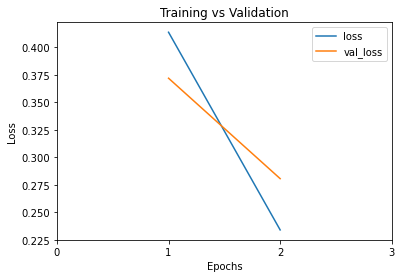

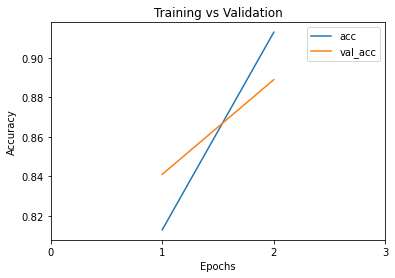

Training done in 7m 28s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2171    343
        -ve    213   2273
---------------------------------------------------
precision:0.9107, recall:0.8636
F1-score :0.8865
accuracy :0.8888
---------------------------------------------------
para/a-dropout-lr_0.25_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  17021570
Epoch [1/2], loss: 0.4019 - acc: 0.8179 - val_loss: 0.3317 - val_acc: 0.8550
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2642 - acc: 0.8948 - val_loss: 0.2974 - val_acc: 0.8890
Checkpoint Saved! Epoch 2 is better.***************************


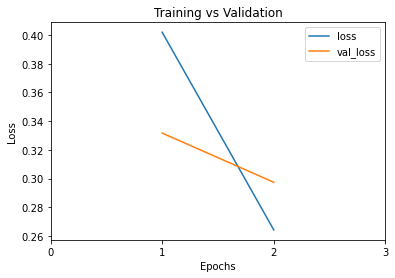

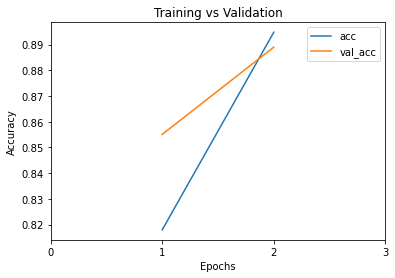

Training done in 7m 25s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2235    279
        -ve    276   2210
---------------------------------------------------
precision:0.8901, recall:0.8890
F1-score :0.8896
accuracy :0.8890
---------------------------------------------------
para/a-dropout-lr_0.25_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  17021570
Epoch [1/2], loss: 0.4687 - acc: 0.7706 - val_loss: 0.3988 - val_acc: 0.8167
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3258 - acc: 0.8618 - val_loss: 0.3219 - val_acc: 0.8684
Checkpoint Saved! Epoch 2 is better.***************************


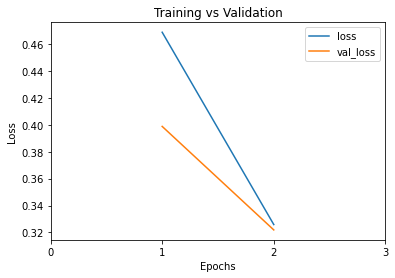

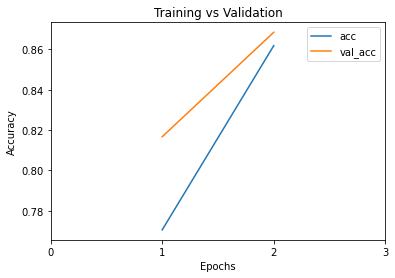

Training done in 7m 1s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2138    376
        -ve    282   2204
---------------------------------------------------
precision:0.8835, recall:0.8504
F1-score :0.8666
accuracy :0.8684
---------------------------------------------------
para/a-dropout-lr_0.5_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  17021570
Epoch [1/2], loss: 0.3739 - acc: 0.8344 - val_loss: 0.3136 - val_acc: 0.8658
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2147 - acc: 0.9227 - val_loss: 0.3154 - val_acc: 0.9008
Checkpoint Saved! Epoch 2 is better.***************************


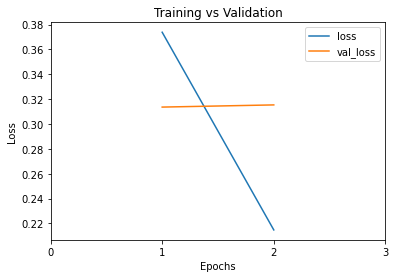

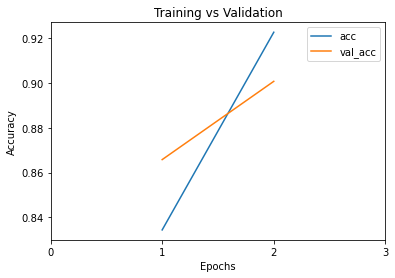

Training done in 7m 19s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2205    309
        -ve    188   2298
---------------------------------------------------
precision:0.9214, recall:0.8771
F1-score :0.8987
accuracy :0.9006
---------------------------------------------------
para/a-dropout-lr_0.5_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  17021570
Epoch [1/2], loss: 0.4035 - acc: 0.8173 - val_loss: 0.3304 - val_acc: 0.8572
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2664 - acc: 0.8942 - val_loss: 0.3038 - val_acc: 0.8816
Checkpoint Saved! Epoch 2 is better.***************************


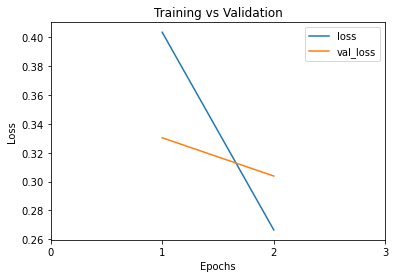

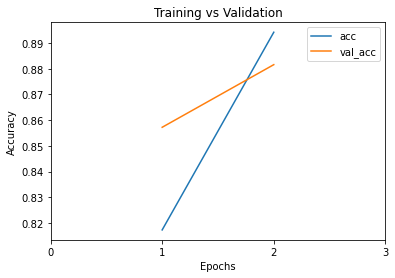

Training done in 7m 9s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2153    361
        -ve    231   2255
---------------------------------------------------
precision:0.9031, recall:0.8564
F1-score :0.8791
accuracy :0.8816
---------------------------------------------------
para/a-dropout-lr_0.5_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  17021570
Epoch [1/2], loss: 0.4719 - acc: 0.7688 - val_loss: 0.3996 - val_acc: 0.8187
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3282 - acc: 0.8591 - val_loss: 0.3253 - val_acc: 0.8658
Checkpoint Saved! Epoch 2 is better.***************************


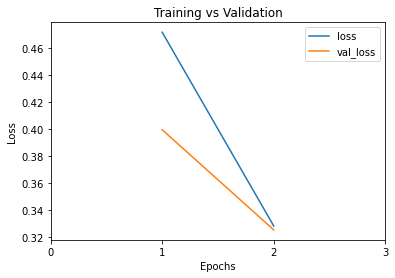

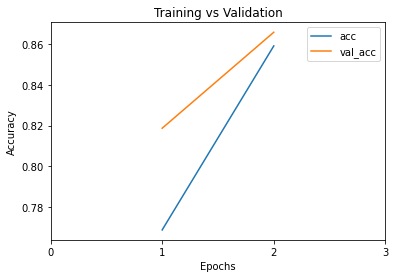

Training done in 7m 25s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2135    379
        -ve    293   2193
---------------------------------------------------
precision:0.8793, recall:0.8492
F1-score :0.8640
accuracy :0.8656
---------------------------------------------------
para/a-dropout-lr_0.6_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  17021570
Epoch [1/2], loss: 0.4072 - acc: 0.8188 - val_loss: 0.3069 - val_acc: 0.8732
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2271 - acc: 0.9174 - val_loss: 0.2636 - val_acc: 0.8984
Checkpoint Saved! Epoch 2 is better.***************************


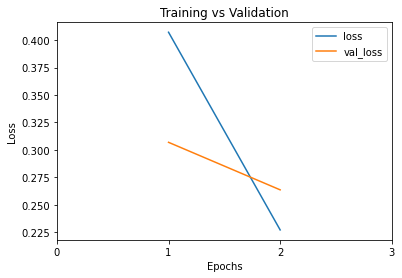

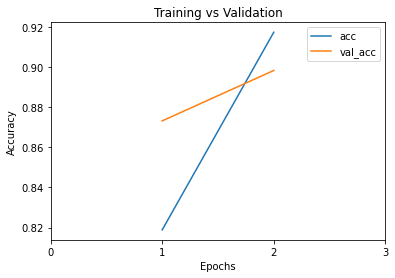

Training done in 7m 53s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2304    210
        -ve    299   2187
---------------------------------------------------
precision:0.8851, recall:0.9165
F1-score :0.9005
accuracy :0.8982
---------------------------------------------------
para/a-dropout-lr_0.6_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  17021570
Epoch [1/2], loss: 0.4068 - acc: 0.8153 - val_loss: 0.3318 - val_acc: 0.8562
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2684 - acc: 0.8931 - val_loss: 0.2969 - val_acc: 0.8852
Checkpoint Saved! Epoch 2 is better.***************************


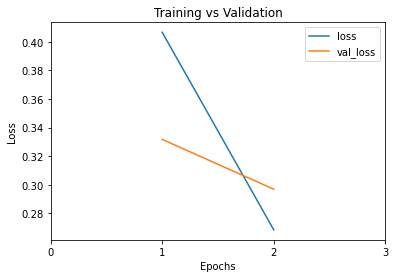

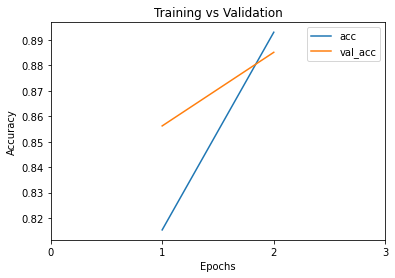

Training done in 7m 17s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2181    333
        -ve    241   2245
---------------------------------------------------
precision:0.9005, recall:0.8675
F1-score :0.8837
accuracy :0.8852
---------------------------------------------------
para/a-dropout-lr_0.6_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  17021570
Epoch [1/2], loss: 0.4727 - acc: 0.7666 - val_loss: 0.4093 - val_acc: 0.8119
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3293 - acc: 0.8592 - val_loss: 0.3254 - val_acc: 0.8634
Checkpoint Saved! Epoch 2 is better.***************************


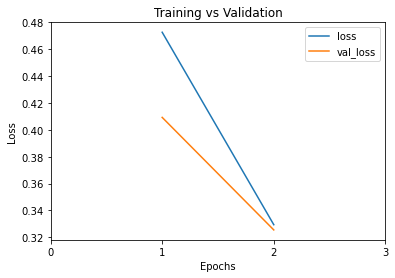

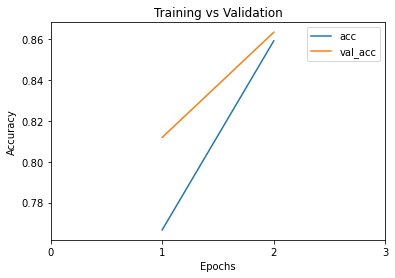

Training done in 7m 14s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2119    395
        -ve    289   2197
---------------------------------------------------
precision:0.8800, recall:0.8429
F1-score :0.8610
accuracy :0.8632
---------------------------------------------------
--------<<<-------best validation accuracy: 0.9006, best hyperparameters:0.5, 0.001 -------->>>--------


In [46]:
# Attention LSTM tuning 1

name_tuning = 'a-dropout-lr'

EMBED_SIZE = 256
HIDDEN_SIZE = 1024
n_layers = 1
bidirectional = True

list1 = [0.25, 0.5, 0.6]                  #change search space to suit needs----------------------<<<
list2 = [1e-3, 3e-4, 1e-4]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        dropout, LR = i, j                                                                        #change variable names----------------------<<<
        model = AttentionLSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional=bidirectional, dropout=dropout).to(device)          #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [47]:
print('Accuracy    ',end='')
for j in list2:
    print(' lr={}'.format(j),end='')
    
for i in list1:
    print('')
    print('dropout='+str(i)+'  ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'%   ', end='')

Accuracy     lr=0.001 lr=0.0003 lr=0.0001
dropout=0.25  88.88%   88.90%   86.84%   
dropout=0.5  90.06%   88.16%   86.56%   
dropout=0.6  89.82%   88.52%   86.32%   

In [48]:
best_a={}
best_a['dropout']=best_hyper1
best_a['LR']=best_hyper2

para/a-embed-hidden_128_512.pth -----------------------------------------------------------------
No of trainable parameters:  5889410
Epoch [1/2], loss: 0.3896 - acc: 0.8234 - val_loss: 0.3638 - val_acc: 0.8446
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2375 - acc: 0.9109 - val_loss: 0.2921 - val_acc: 0.8956
Checkpoint Saved! Epoch 2 is better.***************************


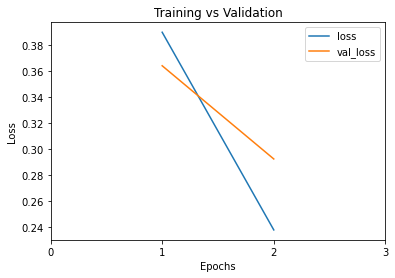

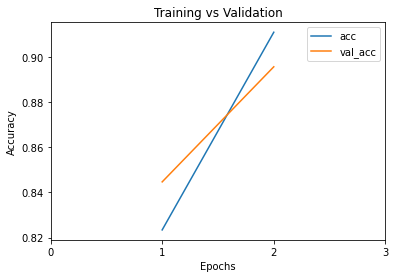

Training done in 6m 12s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2272    242
        -ve    281   2205
---------------------------------------------------
precision:0.8899, recall:0.9037
F1-score :0.8968
accuracy :0.8954
---------------------------------------------------
para/a-embed-hidden_128_1024.pth -----------------------------------------------------------------
No of trainable parameters:  12746626
Epoch [1/2], loss: 0.6234 - acc: 0.6480 - val_loss: 0.5032 - val_acc: 0.7446
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.3657 - acc: 0.8428 - val_loss: 0.2770 - val_acc: 0.8840
Checkpoint Saved! Epoch 2 is better.***************************


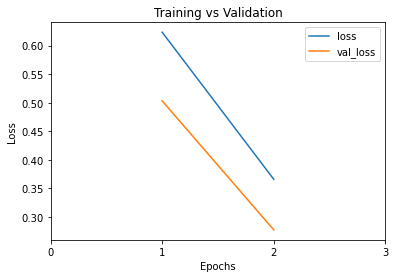

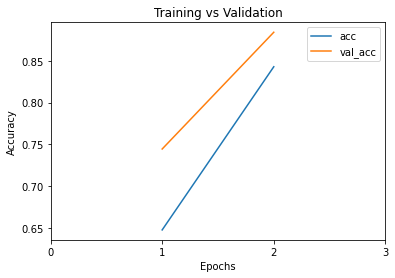

Training done in 7m 9s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2264    250
        -ve    330   2156
---------------------------------------------------
precision:0.8728, recall:0.9006
F1-score :0.8865
accuracy :0.8840
---------------------------------------------------
para/a-embed-hidden_128_2048.pth -----------------------------------------------------------------
No of trainable parameters:  39043970
Epoch [1/2], loss: 0.5394 - acc: 0.7086 - val_loss: 0.3312 - val_acc: 0.8486
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2819 - acc: 0.8872 - val_loss: 0.2679 - val_acc: 0.8874
Checkpoint Saved! Epoch 2 is better.***************************


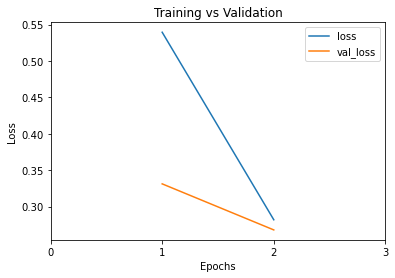

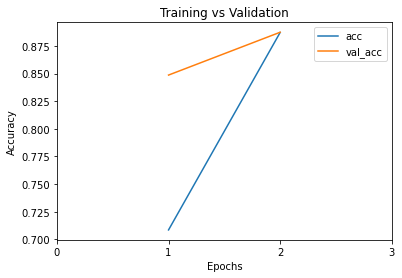

Training done in 11m 16s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2251    263
        -ve    301   2185
---------------------------------------------------
precision:0.8821, recall:0.8954
F1-score :0.8887
accuracy :0.8872
---------------------------------------------------
para/a-embed-hidden_256_512.pth -----------------------------------------------------------------
No of trainable parameters:  9640066
Epoch [1/2], loss: 0.3573 - acc: 0.8454 - val_loss: 0.2681 - val_acc: 0.8936
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2082 - acc: 0.9247 - val_loss: 0.2826 - val_acc: 0.9038
Checkpoint Saved! Epoch 2 is better.***************************


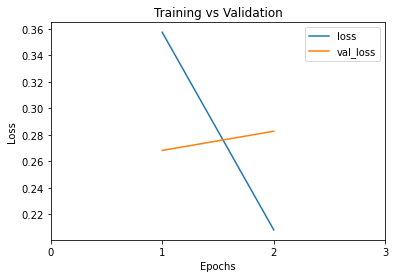

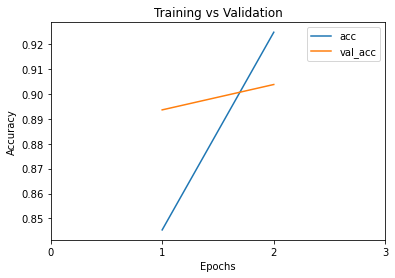

Training done in 6m 13s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2255    259
        -ve    223   2263
---------------------------------------------------
precision:0.9100, recall:0.8970
F1-score :0.9034
accuracy :0.9036
---------------------------------------------------
para/a-embed-hidden_256_1024.pth -----------------------------------------------------------------
No of trainable parameters:  17021570
Epoch [1/2], loss: 0.3739 - acc: 0.8344 - val_loss: 0.3136 - val_acc: 0.8658
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2147 - acc: 0.9227 - val_loss: 0.3154 - val_acc: 0.9008
Checkpoint Saved! Epoch 2 is better.***************************


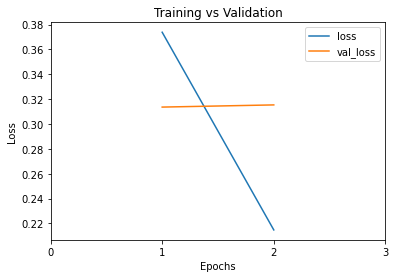

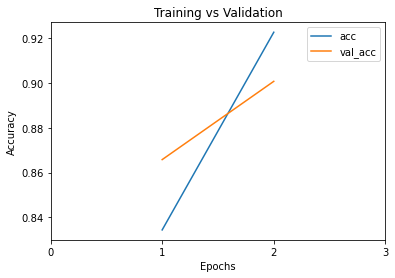

Training done in 7m 6s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2205    309
        -ve    188   2298
---------------------------------------------------
precision:0.9214, recall:0.8771
F1-score :0.8987
accuracy :0.9006
---------------------------------------------------
para/a-embed-hidden_256_2048.pth -----------------------------------------------------------------
No of trainable parameters:  44367490
Epoch [1/2], loss: 0.5502 - acc: 0.7038 - val_loss: 0.3600 - val_acc: 0.8522
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.2794 - acc: 0.8924 - val_loss: 0.2602 - val_acc: 0.8890
Checkpoint Saved! Epoch 2 is better.***************************


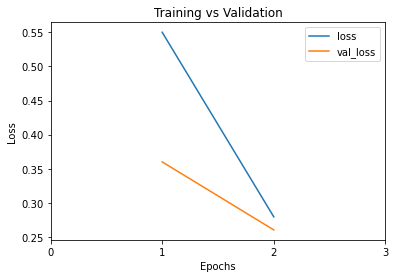

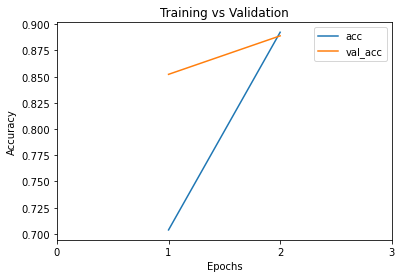

Training done in 11m 17s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2187    327
        -ve    229   2257
---------------------------------------------------
precision:0.9052, recall:0.8699
F1-score :0.8872
accuracy :0.8888
---------------------------------------------------
para/a-embed-hidden_512_512.pth -----------------------------------------------------------------
No of trainable parameters:  17141378
Epoch [1/2], loss: 0.3292 - acc: 0.8626 - val_loss: 0.2871 - val_acc: 0.8868
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.1811 - acc: 0.9393 - val_loss: 0.3293 - val_acc: 0.9062
Checkpoint Saved! Epoch 2 is better.***************************


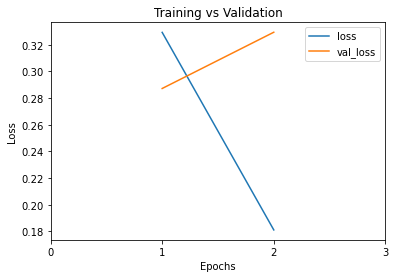

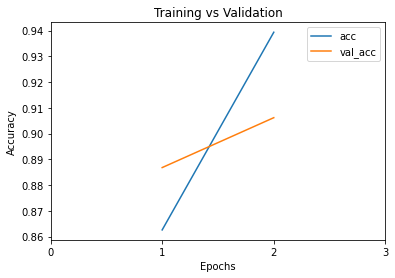

Training done in 6m 26s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2250    264
        -ve    205   2281
---------------------------------------------------
precision:0.9165, recall:0.8950
F1-score :0.9056
accuracy :0.9062
---------------------------------------------------
para/a-embed-hidden_512_1024.pth -----------------------------------------------------------------
No of trainable parameters:  25571458
Epoch [1/2], loss: 0.3383 - acc: 0.8564 - val_loss: 0.2896 - val_acc: 0.8822
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 0.1868 - acc: 0.9371 - val_loss: 0.2898 - val_acc: 0.9071
Checkpoint Saved! Epoch 2 is better.***************************


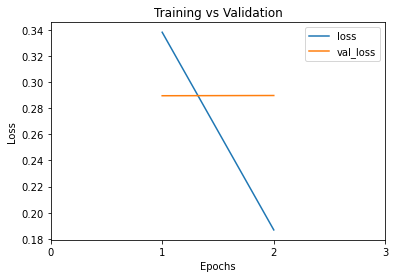

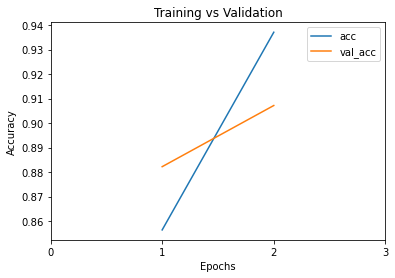

Training done in 7m 9s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2326    188
        -ve    277   2209
---------------------------------------------------
precision:0.8936, recall:0.9252
F1-score :0.9091
accuracy :0.9070
---------------------------------------------------
para/a-embed-hidden_512_2048.pth -----------------------------------------------------------------
No of trainable parameters:  55014530
Epoch [2/2], loss: 0.2005 - acc: 0.9299 - val_loss: 0.3001 - val_acc: 0.9071
Checkpoint Saved! Epoch 2 is better.***************************


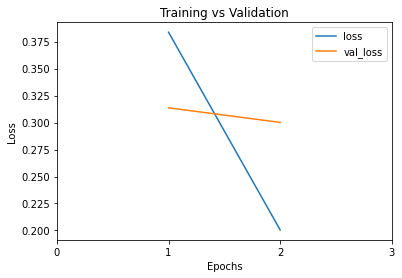

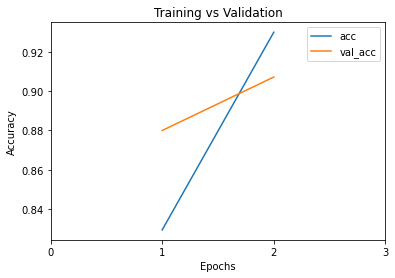

Training done in 11m 19s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2278    236
        -ve    229   2257
---------------------------------------------------
precision:0.9087, recall:0.9061
F1-score :0.9074
accuracy :0.9070
---------------------------------------------------
--------<<<-------best validation accuracy: 0.9070, best hyperparameters:512, 1024 -------->>>--------


In [49]:
# Attention LSTM tuning 2

name_tuning = 'a-embed-hidden'

n_layers = 1
bidirectional = True
dropout = best_hyper1
LR = best_hyper2

list1 = [128, 256, 512]                  #change search space to suit needs----------------------<<<
list2 = [512, 1024, 2048]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        EMBED_SIZE, HIDDEN_SIZE = i, j                                                                        #change variable names----------------------<<<
        model = AttentionLSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional=bidirectional, dropout=dropout).to(device)            #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [50]:
print('Accuracy',end='')
for j in list2:
    print('  hidden={}'.format(j),end='')
    
for i in list1:
    print('')
    print('embed='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'%      ', end='')

Accuracy  hidden=512  hidden=1024  hidden=2048
embed=128      89.54%      88.40%      88.72%      
embed=256      90.36%      90.06%      88.88%      
embed=512      90.62%      90.70%      90.70%      

In [51]:
best_a['EMBED_SIZE'] = best_hyper1
best_a['HIDDEN_SIZE'] = best_hyper2

## Tuning Transformer

para/t-dropout-lr_0.25_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Epoch [1/2], loss: 157.0281 - acc: 0.5018 - val_loss: 100.6472 - val_acc: 0.4966
Checkpoint Saved! Epoch 1 is better.***************************
 Step: [496/2500], loss: 70.8869 - acc: 0.25000

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch [2/2], loss: 33.1793 - acc: 0.5028 - val_loss: 1.2506 - val_acc: 0.4964
early stop at epoch 2 *************************************


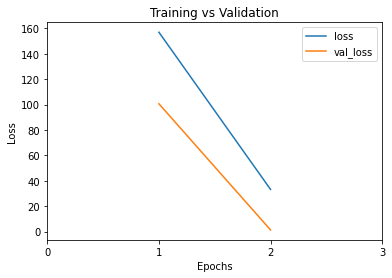

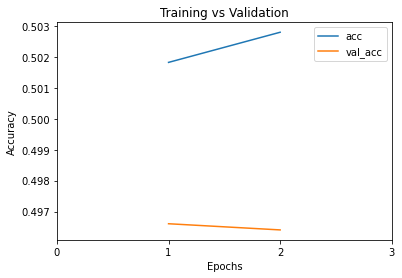

Training done in 5m 11s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve      0   2514
        -ve      1   2485
---------------------------------------------------
precision:0.0000, recall:0.0000
F1-score :nan
accuracy :0.4970
---------------------------------------------------


/tmp/ipykernel_142972/3029608983.py:52: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*precision*recall/(precision+recall)      #harmonic mean


para/t-dropout-lr_0.25_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Epoch [1/2], loss: 32.9139 - acc: 0.6636 - val_loss: 25.6805 - val_acc: 0.7796
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 24.9444 - acc: 0.7833 - val_loss: 10.3833 - val_acc: 0.8421
Checkpoint Saved! Epoch 2 is better.***************************


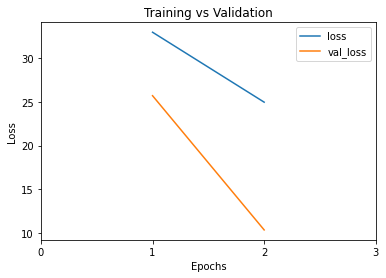

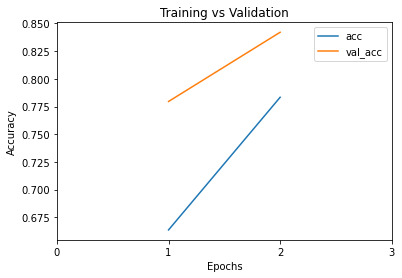

Training done in 5m 20s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1973    541
        -ve    249   2237
---------------------------------------------------
precision:0.8879, recall:0.7848
F1-score :0.8332
accuracy :0.8420
---------------------------------------------------
para/t-dropout-lr_0.25_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Epoch [1/2], loss: 15.1837 - acc: 0.6232 - val_loss: 6.7199 - val_acc: 0.7917
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 10.1656 - acc: 0.7657 - val_loss: 5.9862 - val_acc: 0.8289
Checkpoint Saved! Epoch 2 is better.***************************


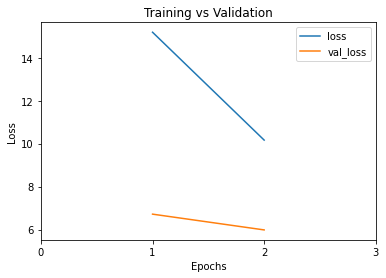

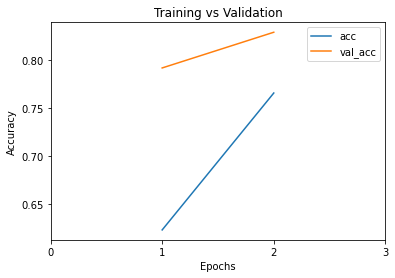

Training done in 4m 41s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1929    585
        -ve    271   2215
---------------------------------------------------
precision:0.8768, recall:0.7673
F1-score :0.8184
accuracy :0.8288
---------------------------------------------------
para/t-dropout-lr_0.5_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Epoch [1/2], loss: 196.1742 - acc: 0.5783 - val_loss: 69.5443 - val_acc: 0.6983
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 63.1842 - acc: 0.6100 - val_loss: 8.1204 - val_acc: 0.7396
Checkpoint Saved! Epoch 2 is better.***************************


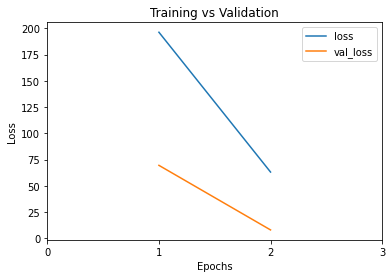

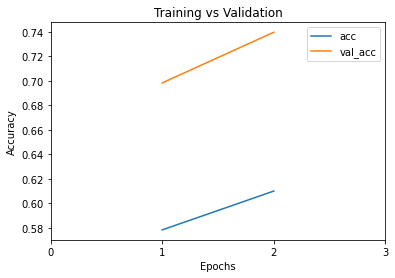

Training done in 5m 8s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1926    588
        -ve    716   1770
---------------------------------------------------
precision:0.7290, recall:0.7661
F1-score :0.7471
accuracy :0.7392
---------------------------------------------------
para/t-dropout-lr_0.5_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Epoch [1/2], loss: 66.6022 - acc: 0.6100 - val_loss: 58.8741 - val_acc: 0.7889
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 49.5370 - acc: 0.7423 - val_loss: 34.8486 - val_acc: 0.8383
Checkpoint Saved! Epoch 2 is better.***************************


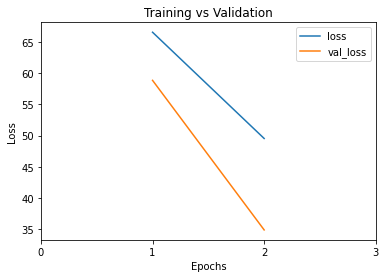

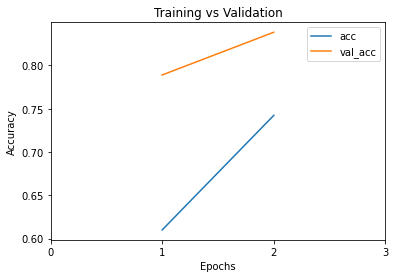

Training done in 5m 22s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2024    490
        -ve    320   2166
---------------------------------------------------
precision:0.8635, recall:0.8051
F1-score :0.8333
accuracy :0.8380
---------------------------------------------------
para/t-dropout-lr_0.5_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Epoch [1/2], loss: 29.9739 - acc: 0.5903 - val_loss: 14.9069 - val_acc: 0.7624
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 22.7062 - acc: 0.7135 - val_loss: 13.9685 - val_acc: 0.8349
Checkpoint Saved! Epoch 2 is better.***************************


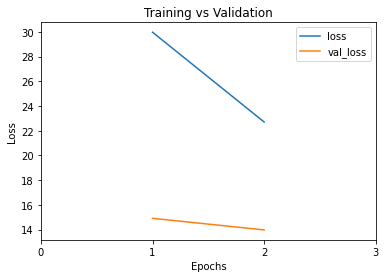

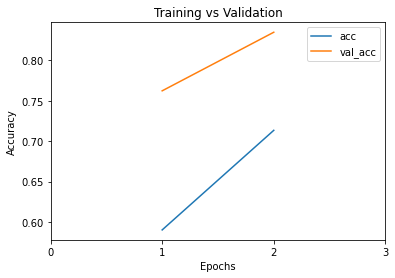

Training done in 4m 16s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2198    316
        -ve    511   1975
---------------------------------------------------
precision:0.8114, recall:0.8743
F1-score :0.8417
accuracy :0.8346
---------------------------------------------------
para/t-dropout-lr_0.6_0.001.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Epoch [1/2], loss: 237.2940 - acc: 0.5242 - val_loss: 159.6786 - val_acc: 0.6897
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 67.7430 - acc: 0.5880 - val_loss: 11.8394 - val_acc: 0.7187
Checkpoint Saved! Epoch 2 is better.***************************


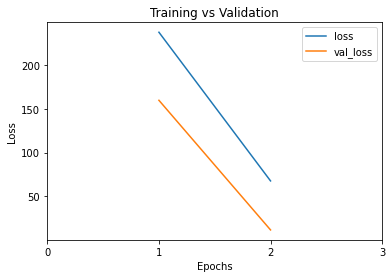

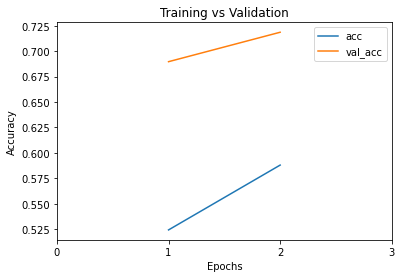

Training done in 4m 29s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1668    846
        -ve    563   1923
---------------------------------------------------
precision:0.7476, recall:0.6635
F1-score :0.7031
accuracy :0.7182
---------------------------------------------------
para/t-dropout-lr_0.6_0.0003.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Epoch [1/2], loss: 83.0286 - acc: 0.5706 - val_loss: 75.4713 - val_acc: 0.7628
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 68.8393 - acc: 0.7087 - val_loss: 54.2789 - val_acc: 0.8417
Checkpoint Saved! Epoch 2 is better.***************************


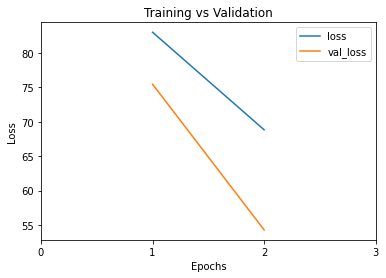

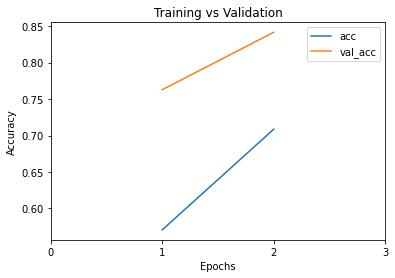

Training done in 4m 34s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2084    430
        -ve    363   2123
---------------------------------------------------
precision:0.8517, recall:0.8290
F1-score :0.8402
accuracy :0.8414
---------------------------------------------------
para/t-dropout-lr_0.6_0.0001.pth -----------------------------------------------------------------
No of trainable parameters:  23804631
Epoch [1/2], loss: 33.9701 - acc: 0.5591 - val_loss: 38.2608 - val_acc: 0.7133
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 34.6049 - acc: 0.6601 - val_loss: 20.5606 - val_acc: 0.7961
Checkpoint Saved! Epoch 2 is better.***************************


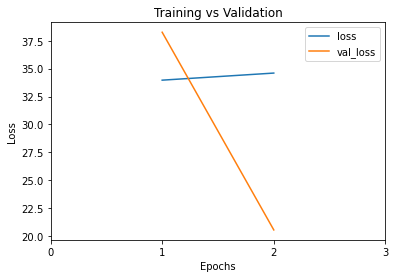

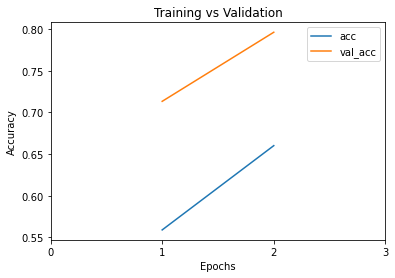

Training done in 5m 15s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1854    660
        -ve    359   2127
---------------------------------------------------
precision:0.8378, recall:0.7375
F1-score :0.7844
accuracy :0.7962
---------------------------------------------------
--------<<<-------best validation accuracy: 0.8420, best hyperparameters:0.25, 0.0003 -------->>>--------


In [52]:
# Transformer tuning 1

name_tuning = 't-dropout-lr'

EMBED_SIZE = 256   # embed_dim must be divisible by num_heads
num_heads = 4      # embed_dim must be divisible by num_heads
HIDDEN_SIZE = 256
n_layers = 2

list1 = [0.25, 0.5, 0.6]                  #change search space to suit needs----------------------<<<
list2 = [1e-3, 3e-4, 1e-4]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        dropout, LR = i, j                                                                        #change variable names----------------------<<<
        model = Transformer(vocab_size, EMBED_SIZE, num_heads, HIDDEN_SIZE, n_layers, MAX_LEN, dropout).to(device)          #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [53]:
print('Accuracy    ',end='')
for j in list2:
    print(' lr={}'.format(j),end='')
    
for i in list1:
    print('')
    print('dropout='+str(i)+'  ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'%   ', end='')

Accuracy     lr=0.001 lr=0.0003 lr=0.0001
dropout=0.25  49.70%   84.20%   82.88%   
dropout=0.5  73.92%   83.80%   83.46%   
dropout=0.6  71.82%   84.14%   79.62%   

In [54]:
best_t={}
best_t['dropout']=best_hyper1
best_t['LR']=best_hyper2

para/t-embed-hidden_128_512.pth -----------------------------------------------------------------
No of trainable parameters:  16956887
Epoch [1/2], loss: 24.6191 - acc: 0.6272 - val_loss: 15.4665 - val_acc: 0.8051
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 13.9407 - acc: 0.7992 - val_loss: 6.0361 - val_acc: 0.8622
Checkpoint Saved! Epoch 2 is better.***************************


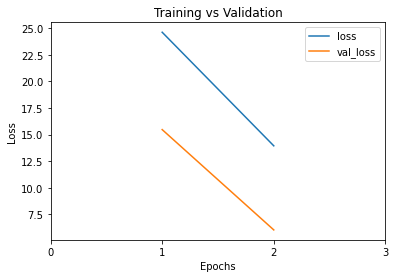

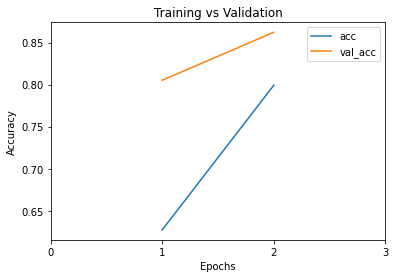

Training done in 5m 9s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2059    455
        -ve    235   2251
---------------------------------------------------
precision:0.8976, recall:0.8190
F1-score :0.8565
accuracy :0.8620
---------------------------------------------------
para/t-embed-hidden_128_1024.pth -----------------------------------------------------------------
No of trainable parameters:  17220055
Epoch [1/2], loss: 27.1089 - acc: 0.6288 - val_loss: 11.6071 - val_acc: 0.8001
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 13.1313 - acc: 0.7939 - val_loss: 4.1374 - val_acc: 0.8616
Checkpoint Saved! Epoch 2 is better.***************************


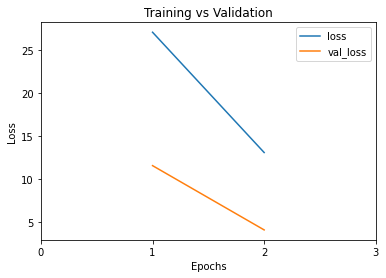

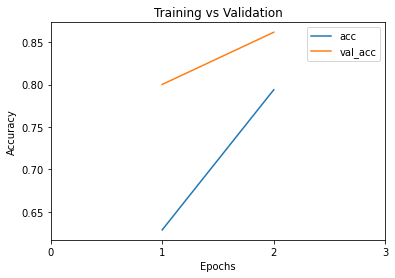

Training done in 4m 56s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2111    403
        -ve    290   2196
---------------------------------------------------
precision:0.8792, recall:0.8397
F1-score :0.8590
accuracy :0.8614
---------------------------------------------------
para/t-embed-hidden_128_2048.pth -----------------------------------------------------------------
No of trainable parameters:  17746391
Epoch [1/2], loss: 30.4744 - acc: 0.6243 - val_loss: 13.3664 - val_acc: 0.8327
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 14.4966 - acc: 0.8021 - val_loss: 5.2412 - val_acc: 0.8670
Checkpoint Saved! Epoch 2 is better.***************************


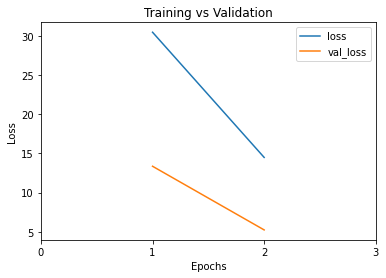

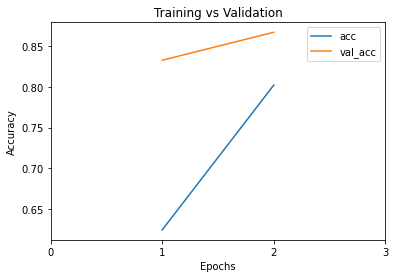

Training done in 4m 49s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2297    217
        -ve    449   2037
---------------------------------------------------
precision:0.8365, recall:0.9137
F1-score :0.8734
accuracy :0.8668
---------------------------------------------------
para/t-embed-hidden_256_512.pth -----------------------------------------------------------------
No of trainable parameters:  24067287
Epoch [1/2], loss: 33.0318 - acc: 0.6615 - val_loss: 20.4802 - val_acc: 0.8077
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 27.4674 - acc: 0.7705 - val_loss: 12.2397 - val_acc: 0.8381
Checkpoint Saved! Epoch 2 is better.***************************


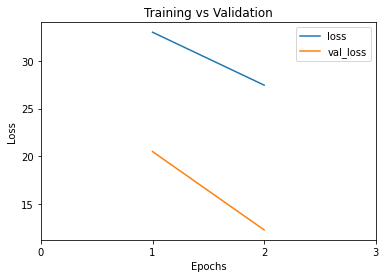

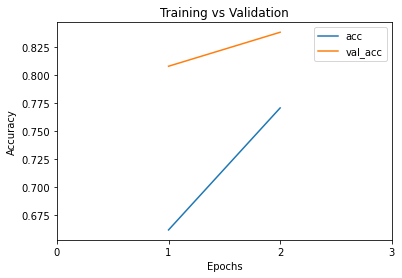

Training done in 4m 57s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2163    351
        -ve    460   2026
---------------------------------------------------
precision:0.8246, recall:0.8604
F1-score :0.8421
accuracy :0.8378
---------------------------------------------------
para/t-embed-hidden_256_1024.pth -----------------------------------------------------------------
No of trainable parameters:  24592599
Epoch [1/2], loss: 36.1303 - acc: 0.6603 - val_loss: 23.6194 - val_acc: 0.7951
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 29.3470 - acc: 0.7582 - val_loss: 14.8930 - val_acc: 0.8327
Checkpoint Saved! Epoch 2 is better.***************************


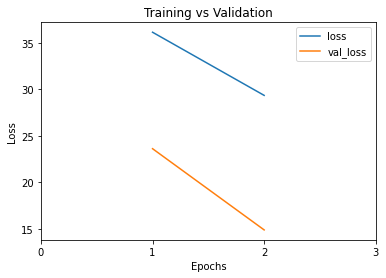

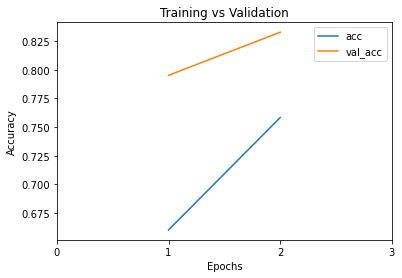

Training done in 4m 46s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2216    298
        -ve    539   1947
---------------------------------------------------
precision:0.8044, recall:0.8815
F1-score :0.8411
accuracy :0.8326
---------------------------------------------------
para/t-embed-hidden_256_2048.pth -----------------------------------------------------------------
No of trainable parameters:  25643223
Epoch [1/2], loss: 36.3594 - acc: 0.6607 - val_loss: 17.3614 - val_acc: 0.8293
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 28.7613 - acc: 0.7648 - val_loss: 14.1008 - val_acc: 0.8175
early stop at epoch 2 *************************************


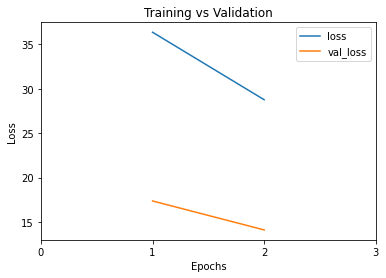

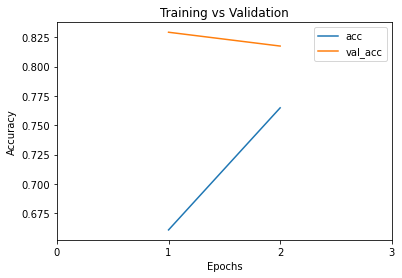

Training done in 4m 27s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1751    763
        -ve    151   2335
---------------------------------------------------
precision:0.9206, recall:0.6965
F1-score :0.7930
accuracy :0.8172
---------------------------------------------------
para/t-embed-hidden_512_512.pth -----------------------------------------------------------------
No of trainable parameters:  39074519
Epoch [1/2], loss: 49.9286 - acc: 0.6418 - val_loss: 26.8843 - val_acc: 0.7812
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 51.6474 - acc: 0.7003 - val_loss: 23.3797 - val_acc: 0.7817
Checkpoint Saved! Epoch 2 is better.***************************


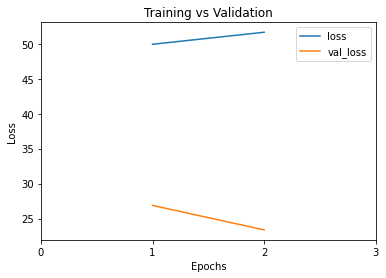

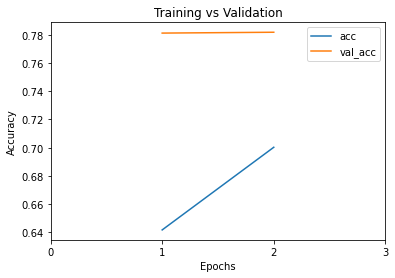

Training done in 5m 2s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   1758    756
        -ve    337   2149
---------------------------------------------------
precision:0.8391, recall:0.6993
F1-score :0.7629
accuracy :0.7814
---------------------------------------------------
para/t-embed-hidden_512_1024.pth -----------------------------------------------------------------
No of trainable parameters:  40124119
Epoch [1/2], loss: 49.9391 - acc: 0.6446 - val_loss: 65.4821 - val_acc: 0.6701
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 50.8016 - acc: 0.7011 - val_loss: 24.4868 - val_acc: 0.7937
Checkpoint Saved! Epoch 2 is better.***************************


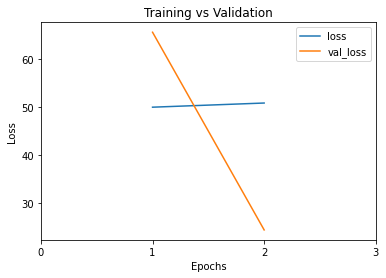

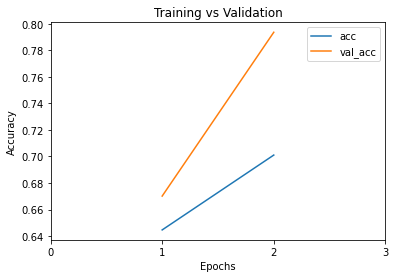

Training done in 5m 35s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2056    458
        -ve    574   1912
---------------------------------------------------
precision:0.7817, recall:0.8178
F1-score :0.7994
accuracy :0.7936
---------------------------------------------------
para/t-embed-hidden_512_2048.pth -----------------------------------------------------------------
No of trainable parameters:  42223319
Epoch [1/2], loss: 48.9984 - acc: 0.6370 - val_loss: 33.1789 - val_acc: 0.7668
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 48.9830 - acc: 0.7111 - val_loss: 21.3366 - val_acc: 0.7993
Checkpoint Saved! Epoch 2 is better.***************************


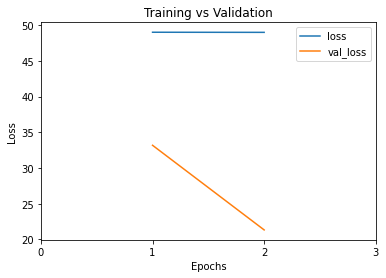

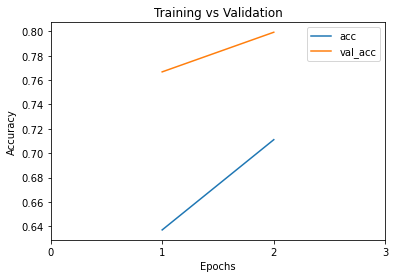

Training done in 4m 54s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2034    480
        -ve    523   1963
---------------------------------------------------
precision:0.7955, recall:0.8091
F1-score :0.8022
accuracy :0.7994
---------------------------------------------------
--------<<<-------best validation accuracy: 0.8668, best hyperparameters:128, 2048 -------->>>--------


In [55]:
# Transformer tuning 2

name_tuning = 't-embed-hidden'

num_heads = 4 
n_layers = 2
dropout = best_hyper1
LR = best_hyper2

list1 = [128, 256, 512]                  #change search space to suit needs----------------------<<<
list2 = [512, 1024, 2048]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        EMBED_SIZE, HIDDEN_SIZE = i, j                                                                        #change variable names----------------------<<<
        model = Transformer(vocab_size, EMBED_SIZE, num_heads, HIDDEN_SIZE, n_layers, MAX_LEN, dropout).to(device)            #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [56]:
print('Accuracy',end='')
for j in list2:
    print('  hidden={}'.format(j),end='')
    
for i in list1:
    print('')
    print('embed='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'%      ', end='')

Accuracy  hidden=512  hidden=1024  hidden=2048
embed=128      86.20%      86.14%      86.68%      
embed=256      83.78%      83.26%      81.72%      
embed=512      78.14%      79.36%      79.94%      

In [57]:
best_t['EMBED_SIZE'] = best_hyper1
best_t['HIDDEN_SIZE'] = best_hyper2

para/t-head-layer_2_1.pth -----------------------------------------------------------------
No of trainable parameters:  17153367
Epoch [1/2], loss: 33.3891 - acc: 0.6347 - val_loss: 18.4897 - val_acc: 0.8119
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 18.8483 - acc: 0.7967 - val_loss: 7.7981 - val_acc: 0.8664
Checkpoint Saved! Epoch 2 is better.***************************


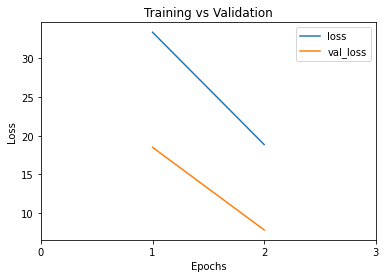

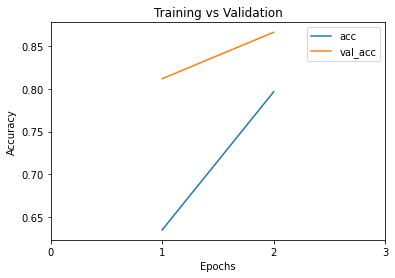

Training done in 4m 23s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2146    368
        -ve    301   2185
---------------------------------------------------
precision:0.8770, recall:0.8536
F1-score :0.8651
accuracy :0.8662
---------------------------------------------------
para/t-head-layer_2_2.pth -----------------------------------------------------------------
No of trainable parameters:  17746391
Epoch [1/2], loss: 29.9835 - acc: 0.6280 - val_loss: 13.3584 - val_acc: 0.8245
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 13.6341 - acc: 0.8039 - val_loss: 5.1660 - val_acc: 0.8446
Checkpoint Saved! Epoch 2 is better.***************************


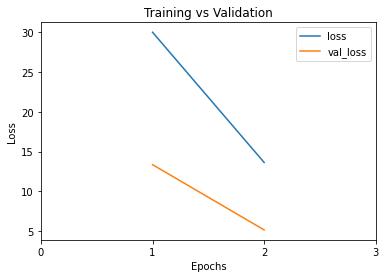

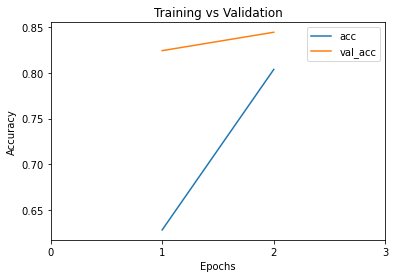

Training done in 4m 53s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2408    106
        -ve    672   1814
---------------------------------------------------
precision:0.7818, recall:0.9578
F1-score :0.8609
accuracy :0.8444
---------------------------------------------------
para/t-head-layer_2_4.pth -----------------------------------------------------------------
No of trainable parameters:  18932439
Epoch [1/2], loss: 25.1926 - acc: 0.6011 - val_loss: 15.0203 - val_acc: 0.8097
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 12.8578 - acc: 0.7823 - val_loss: 4.3148 - val_acc: 0.8548
Checkpoint Saved! Epoch 2 is better.***************************


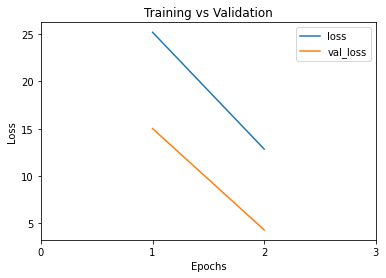

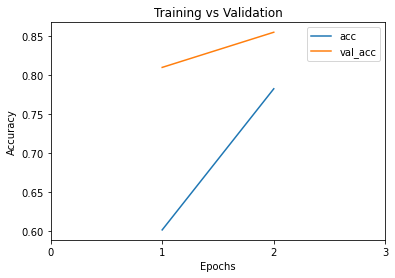

Training done in 5m 29s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2332    182
        -ve    545   1941
---------------------------------------------------
precision:0.8106, recall:0.9276
F1-score :0.8651
accuracy :0.8546
---------------------------------------------------
para/t-head-layer_4_1.pth -----------------------------------------------------------------
No of trainable parameters:  17153367
Epoch [1/2], loss: 34.5762 - acc: 0.6234 - val_loss: 12.1351 - val_acc: 0.8245
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 18.3569 - acc: 0.7936 - val_loss: 5.6800 - val_acc: 0.8562
Checkpoint Saved! Epoch 2 is better.***************************


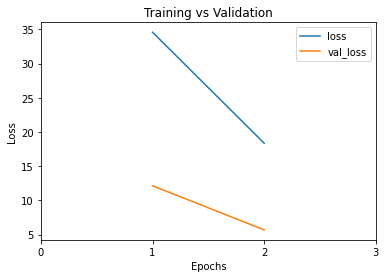

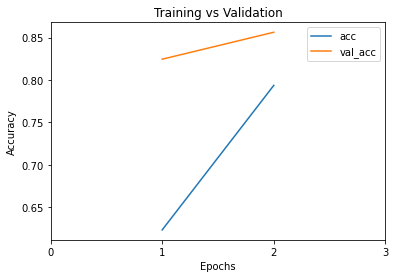

Training done in 4m 44s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2324    190
        -ve    529   1957
---------------------------------------------------
precision:0.8146, recall:0.9244
F1-score :0.8660
accuracy :0.8562
---------------------------------------------------
para/t-head-layer_4_2.pth -----------------------------------------------------------------
No of trainable parameters:  17746391
Epoch [1/2], loss: 30.4744 - acc: 0.6243 - val_loss: 13.3664 - val_acc: 0.8327
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 14.4966 - acc: 0.8021 - val_loss: 5.2412 - val_acc: 0.8670
Checkpoint Saved! Epoch 2 is better.***************************


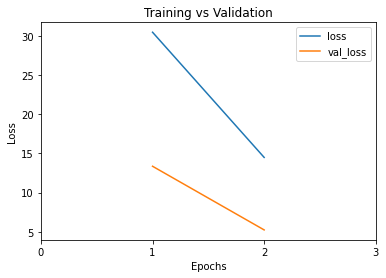

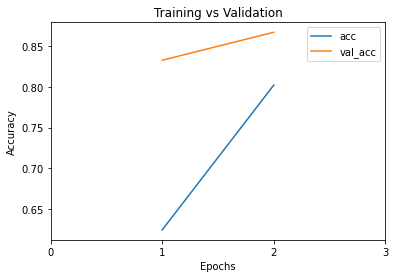

Training done in 4m 52s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2297    217
        -ve    449   2037
---------------------------------------------------
precision:0.8365, recall:0.9137
F1-score :0.8734
accuracy :0.8668
---------------------------------------------------
para/t-head-layer_4_4.pth -----------------------------------------------------------------
No of trainable parameters:  18932439
Epoch [1/2], loss: 24.3069 - acc: 0.6160 - val_loss: 23.3506 - val_acc: 0.7967
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 13.4128 - acc: 0.8001 - val_loss: 5.1938 - val_acc: 0.8784
Checkpoint Saved! Epoch 2 is better.***************************


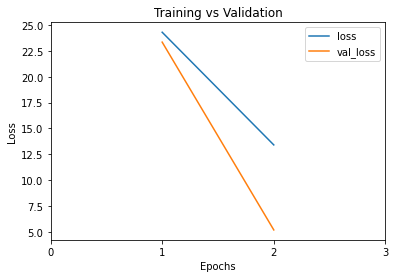

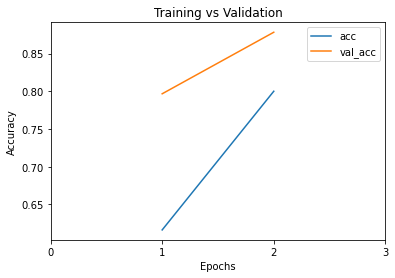

Training done in 5m 13s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2195    319
        -ve    290   2196
---------------------------------------------------
precision:0.8833, recall:0.8731
F1-score :0.8782
accuracy :0.8782
---------------------------------------------------
para/t-head-layer_8_1.pth -----------------------------------------------------------------
No of trainable parameters:  17153367
Epoch [1/2], loss: 34.0504 - acc: 0.6311 - val_loss: 15.5885 - val_acc: 0.8319
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 19.1863 - acc: 0.7980 - val_loss: 7.1604 - val_acc: 0.8632
Checkpoint Saved! Epoch 2 is better.***************************


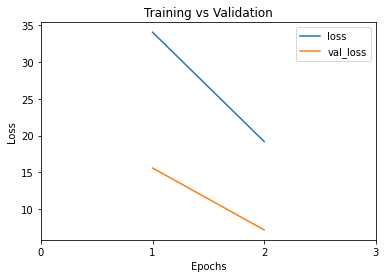

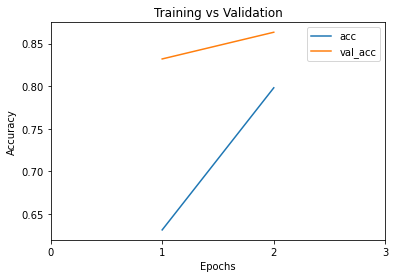

Training done in 4m 36s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2119    395
        -ve    289   2197
---------------------------------------------------
precision:0.8800, recall:0.8429
F1-score :0.8610
accuracy :0.8632
---------------------------------------------------
para/t-head-layer_8_2.pth -----------------------------------------------------------------
No of trainable parameters:  17746391
Epoch [1/2], loss: 29.5485 - acc: 0.6211 - val_loss: 9.8513 - val_acc: 0.8173
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 14.8587 - acc: 0.7988 - val_loss: 4.6158 - val_acc: 0.8656
Checkpoint Saved! Epoch 2 is better.***************************


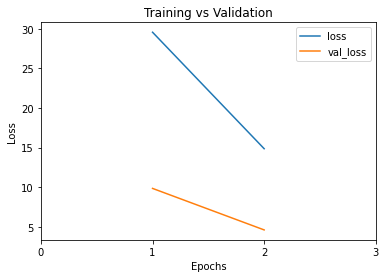

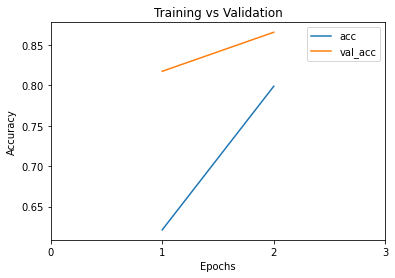

Training done in 5m 19s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2083    431
        -ve    242   2244
---------------------------------------------------
precision:0.8959, recall:0.8286
F1-score :0.8609
accuracy :0.8654
---------------------------------------------------
para/t-head-layer_8_4.pth -----------------------------------------------------------------
No of trainable parameters:  18932439
Epoch [1/2], loss: 23.8117 - acc: 0.6181 - val_loss: 13.4588 - val_acc: 0.8387
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/2], loss: 13.4897 - acc: 0.7975 - val_loss: 6.4713 - val_acc: 0.8700
Checkpoint Saved! Epoch 2 is better.***************************


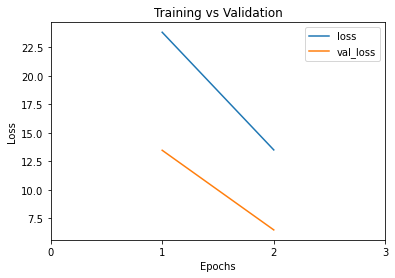

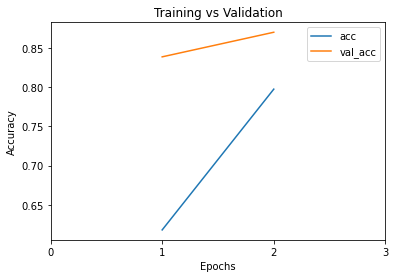

Training done in 5m 19s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2088    426
        -ve    225   2261
---------------------------------------------------
precision:0.9027, recall:0.8305
F1-score :0.8651
accuracy :0.8698
---------------------------------------------------
--------<<<-------best validation accuracy: 0.8782, best hyperparameters:4, 4 -------->>>--------


In [58]:
# Transformer tuning 3

name_tuning = 't-head-layer'

EMBED_SIZE = best_t['EMBED_SIZE']
HIDDEN_SIZE = best_t['HIDDEN_SIZE']
dropout = best_t['dropout']
LR = best_t['LR']

list1 = [2, 4, 8]                  #change search space to suit needs----------------------<<<
list2 = [1, 2, 4]
#-----------------------------------------------------
best_acc=0       #initialize best validation accuracy
best_hyper1, best_hyper2 = None, None
model_trial[name_tuning]={}
acc_trial={}

for i in list1:
    model_trial[name_tuning][i] = {}
    acc_trial[i] = {}
    for j in list2:
        num_heads, n_layers = i, j                                                                        #change variable names----------------------<<<
        model = Transformer(vocab_size, EMBED_SIZE, num_heads, HIDDEN_SIZE, n_layers, MAX_LEN, dropout).to(device)            #change model -----------<<<
        best_acc, best_hyper1, best_hyper2, acc_trial[i][j] = tune_one(model, best_acc, best_hyper1, best_hyper2)
        model_trial[name_tuning][i][j] = model

print('--------<<<-------best validation accuracy: {:.4f}, best hyperparameters:{}, {} -------->>>--------'.format(best_acc, best_hyper1, best_hyper2))

In [59]:
print('Accuracy     ',end='')
for j in list2:
    print('  n_layers={}'.format(j),end='')
    
for i in list1:
    print('')
    print('num_heads='+str(i)+'      ', end='')
    for j in list2:
        print("{:.2f}".format(acc_trial[i][j]*100)+'%      ', end='')

Accuracy       n_layers=1  n_layers=2  n_layers=4
num_heads=2      86.62%      84.44%      85.46%      
num_heads=4      85.62%      86.68%      87.82%      
num_heads=8      86.32%      86.54%      86.98%      

In [60]:
best_t['num_heads'] = best_hyper1
best_t['n_layers'] = best_hyper2

## Final model training and testing

Set helper function and no of epochs:

In [61]:
NUM_EPOCHS = 10

In [62]:
def gen_final(model):
    loss_fn = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.7, 0.99))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    print('No of trainable parameters: ', para_num(model))

    randomize()
    history = train(model, train_dl, valid_dl, loss_fn, optimizer, NUM_EPOCHS, accuracy, device, CHECKPOINT_PATH, scheduler, binaryloss=True, early_stop=False)

    confusion_m, acc, precision, recall = performance(model, valid_dl, binaryloss=True)

    return model

No of trainable parameters:  17364481
Epoch [1/10], loss: 0.6828 - acc: 0.7736 - val_loss: 0.4047 - val_acc: 0.8624
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/10], loss: 0.3167 - acc: 0.9136 - val_loss: 0.5306 - val_acc: 0.8844
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [3/10], loss: 0.1586 - acc: 0.9621 - val_loss: 0.9203 - val_acc: 0.8908
Checkpoint Saved! Epoch 3 is better.***************************
Epoch [4/10], loss: 0.0967 - acc: 0.9808 - val_loss: 1.0939 - val_acc: 0.8870
Epoch [5/10], loss: 0.0652 - acc: 0.9878 - val_loss: 1.2765 - val_acc: 0.8906
Epoch [6/10], loss: 0.0475 - acc: 0.9913 - val_loss: 1.4093 - val_acc: 0.8958
Checkpoint Saved! Epoch 6 is better.***************************
Epoch [7/10], loss: 0.0364 - acc: 0.9936 - val_loss: 1.7306 - val_acc: 0.8952
Epoch [8/10], loss: 0.0238 - acc: 0.9958 - val_loss: 1.7498 - val_acc: 0.8952
Epoch [9/10], loss: 0.0157 - acc: 0.9970 - val_loss: 1.9029 - val_acc: 0.8964
Chec

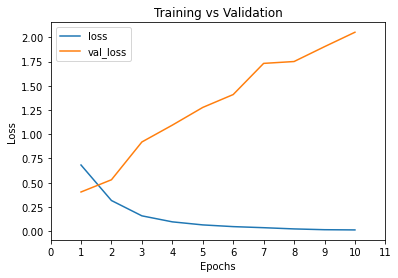

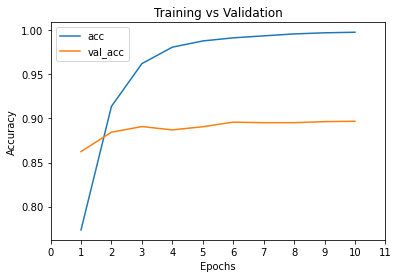

Training done in 36m 1s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2299    215
        -ve    301   2185
---------------------------------------------------
precision:0.8842, recall:0.9145
F1-score :0.8991
accuracy :0.8968
---------------------------------------------------


In [63]:
# final LSTM

EMBED_SIZE = best_l['EMBED_SIZE']
HIDDEN_SIZE = best_l['HIDDEN_SIZE']
n_layers = 1
bidirectional = True
dropout = best_l['dropout']
LR = best_l['LR']

CHECKPOINT_PATH = 'para/final_LSTM.pth'
#-----------------------------------------------------

final_LSTM = LSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)  
final_LSTM = gen_final(final_LSTM)

No of trainable parameters:  16262145
Epoch [1/10], loss: 2.2859 - acc: 0.7655 - val_loss: 2.2033 - val_acc: 0.8395
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/10], loss: 1.5903 - acc: 0.8958 - val_loss: 2.6943 - val_acc: 0.8616
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [3/10], loss: 0.9830 - acc: 0.9418 - val_loss: 3.2968 - val_acc: 0.8642
Checkpoint Saved! Epoch 3 is better.***************************
Epoch [4/10], loss: 0.6910 - acc: 0.9629 - val_loss: 4.2278 - val_acc: 0.8804
Checkpoint Saved! Epoch 4 is better.***************************
Epoch [5/10], loss: 0.4408 - acc: 0.9744 - val_loss: 4.5090 - val_acc: 0.8800
Epoch [6/10], loss: 0.3357 - acc: 0.9813 - val_loss: 5.0236 - val_acc: 0.8842
Checkpoint Saved! Epoch 6 is better.***************************
Epoch [7/10], loss: 0.2559 - acc: 0.9854 - val_loss: 5.2793 - val_acc: 0.8836
Epoch [8/10], loss: 0.1841 - acc: 0.9897 - val_loss: 5.9675 - val_acc: 0.8824
Epoch [9/10], loss

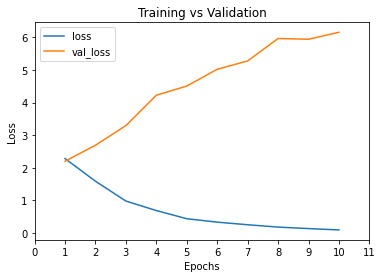

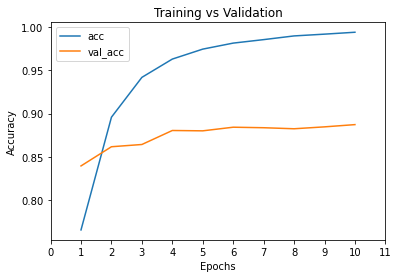

Training done in 29m 28s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2258    256
        -ve    309   2177
---------------------------------------------------
precision:0.8796, recall:0.8982
F1-score :0.8888
accuracy :0.8870
---------------------------------------------------


In [64]:
# final GRU

EMBED_SIZE = best_g['EMBED_SIZE']
HIDDEN_SIZE = best_g['HIDDEN_SIZE']
n_layers = 1
bidirectional = True
dropout = best_g['dropout']
LR = best_g['LR']

CHECKPOINT_PATH = 'para/final_GRU.pth'
#-----------------------------------------------------

final_GRU = GRU(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional, MAX_LEN, dropout).to(device)
final_GRU = gen_final(final_GRU)

No of trainable parameters:  25571458
Epoch [1/10], loss: 0.3346 - acc: 0.8586 - val_loss: 0.2795 - val_acc: 0.8884
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/10], loss: 0.1842 - acc: 0.9385 - val_loss: 0.2879 - val_acc: 0.9052
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [3/10], loss: 0.0895 - acc: 0.9764 - val_loss: 0.4801 - val_acc: 0.9026
Epoch [4/10], loss: 0.0363 - acc: 0.9924 - val_loss: 0.8041 - val_acc: 0.8986
Epoch [5/10], loss: 0.0133 - acc: 0.9971 - val_loss: 1.0225 - val_acc: 0.9042
Epoch [6/10], loss: 0.0076 - acc: 0.9983 - val_loss: 1.2496 - val_acc: 0.9052
Epoch [7/10], loss: 0.0035 - acc: 0.9992 - val_loss: 1.2659 - val_acc: 0.9012
Epoch [8/10], loss: 0.0024 - acc: 0.9995 - val_loss: 1.5304 - val_acc: 0.9028
Epoch [9/10], loss: 0.0009 - acc: 0.9997 - val_loss: 1.5535 - val_acc: 0.9069
Checkpoint Saved! Epoch 9 is better.***************************
Epoch [10/10], loss: 0.0012 - acc: 0.9996 - val_loss: 1.6784 - val_a

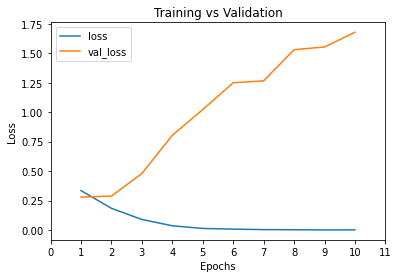

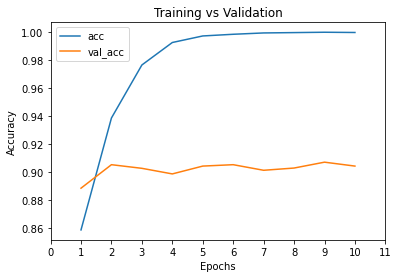

Training done in 37m 32s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2289    225
        -ve    254   2232
---------------------------------------------------
precision:0.9001, recall:0.9105
F1-score :0.9053
accuracy :0.9042
---------------------------------------------------


In [65]:
# final Attention LSTM

EMBED_SIZE = best_a['EMBED_SIZE']
HIDDEN_SIZE = best_a['HIDDEN_SIZE']
n_layers = 1
bidirectional = True
dropout = best_a['dropout']
LR = best_a['LR']

CHECKPOINT_PATH = 'para/final_attentionLSTM.pth'
#-----------------------------------------------------

final_attentionLSTM = AttentionLSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional=bidirectional, dropout=dropout).to(device) 
final_attentionLSTM = gen_final(final_attentionLSTM)

No of trainable parameters:  18932439
Epoch [1/10], loss: 24.1891 - acc: 0.6405 - val_loss: 13.1078 - val_acc: 0.8448
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/10], loss: 13.1390 - acc: 0.8045 - val_loss: 5.9996 - val_acc: 0.8646
Checkpoint Saved! Epoch 2 is better.***************************
Epoch [3/10], loss: 5.9202 - acc: 0.8484 - val_loss: 4.1294 - val_acc: 0.8854
Checkpoint Saved! Epoch 3 is better.***************************
Epoch [4/10], loss: 2.3907 - acc: 0.8723 - val_loss: 1.7205 - val_acc: 0.8878
Checkpoint Saved! Epoch 4 is better.***************************
Epoch [5/10], loss: 1.2023 - acc: 0.8916 - val_loss: 0.9477 - val_acc: 0.8836
Epoch [6/10], loss: 0.7083 - acc: 0.9097 - val_loss: 0.9393 - val_acc: 0.8866
Epoch [7/10], loss: 0.4853 - acc: 0.9231 - val_loss: 0.9547 - val_acc: 0.8840
Epoch [8/10], loss: 0.3638 - acc: 0.9366 - val_loss: 0.9963 - val_acc: 0.8660
Epoch [9/10], loss: 0.2860 - acc: 0.9476 - val_loss: 1.0120 - val_acc: 0.8852
E

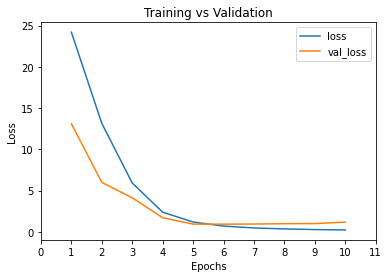

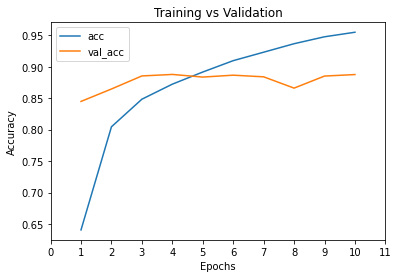

Training done in 27m 27s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2276    238
        -ve    325   2161
---------------------------------------------------
precision:0.8750, recall:0.9053
F1-score :0.8899
accuracy :0.8874
---------------------------------------------------


In [66]:
# final transformer

EMBED_SIZE = best_t['EMBED_SIZE']
HIDDEN_SIZE = best_t['HIDDEN_SIZE']
num_heads = best_t['num_heads']
n_layers = best_t['n_layers']
dropout = best_t['dropout']
LR = best_t['LR']

CHECKPOINT_PATH = 'para/final_transformer.pth'
#-----------------------------------------------------

final_transformer = Transformer(vocab_size, EMBED_SIZE, num_heads, HIDDEN_SIZE, n_layers, MAX_LEN, dropout).to(device)
final_transformer = gen_final(final_transformer)

## Generalization - Restaurant reviews

In [67]:
opentable_df = pd.read_csv("data/opentable.csv")
opentable_ds = TextClassDataset(opentable_df, tokenizer, CLASSES, VOCAB_PATH, MAX_LEN, MIN_COUNT, stopwords)
opentable_dl = DataLoader(opentable_ds, batch_size=100, shuffle=False)

In [68]:
cm, acc, precision, recall = performance(final_LSTM, opentable_dl)

---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve     46      4
        -ve     16     34
---------------------------------------------------
precision:0.7419, recall:0.9200
F1-score :0.8214
accuracy :0.8000
---------------------------------------------------


In [69]:
cm, acc, precision, recall = performance(final_GRU, opentable_dl)

---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve     50      0
        -ve     18     32
---------------------------------------------------
precision:0.7353, recall:1.0000
F1-score :0.8475
accuracy :0.8200
---------------------------------------------------


In [70]:
cm, acc, precision, recall = performance(final_attentionLSTM, opentable_dl)

---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve     49      1
        -ve     13     37
---------------------------------------------------
precision:0.7903, recall:0.9800
F1-score :0.8750
accuracy :0.8600
---------------------------------------------------


In [71]:
cm, acc, precision, recall = performance(final_transformer, opentable_dl)

---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve     42      8
        -ve     10     40
---------------------------------------------------
precision:0.8077, recall:0.8400
F1-score :0.8235
accuracy :0.8200
---------------------------------------------------


In [72]:
# placeholder, not yet finalized
# not needed if don't need to load weights

#EMBED_SIZE = 256
#HIDDEN_SIZE = 1024
#n_layers = 1
#bidirectional = True
#dropout = 0.5
#final_attention_model = AttentionLSTM(vocab_size, EMBED_SIZE, HIDDEN_SIZE, 1, n_layers, bidirectional=True, dropout=dropout).to(device)
#final_attention_model.load_state_dict(torch.load('para/attentionLSTM.pth'))

###  explore some wrong predictions...

In [73]:
pred_all, out_all, label_all = predict(final_LSTM, opentable_dl)
torch.where(pred_all != label_all)

(tensor([ 4,  9, 10, 12, 15, 16, 21, 22, 26, 35, 37, 48, 50, 57, 60, 62, 66, 67,
         75, 77], device='cuda:0'),)

In [74]:
pred_all, out_all, label_all = predict(final_GRU, opentable_dl)
torch.where(pred_all != label_all)

(tensor([ 0,  9, 10, 21, 22, 29, 32, 34, 48, 50, 57, 62, 66, 67, 75, 77, 84, 93],
        device='cuda:0'),)

In [75]:
pred_all, out_all, label_all = predict(final_attentionLSTM, opentable_dl)
torch.where(pred_all != label_all)

(tensor([ 0, 21, 22, 29, 32, 35, 37, 50, 57, 62, 64, 67, 75, 84],
        device='cuda:0'),)

In [76]:
pred_all, out_all, label_all = predict(final_transformer, opentable_dl)
torch.where(pred_all != label_all)

(tensor([ 4, 14, 15, 21, 29, 31, 32, 50, 56, 57, 58, 60, 62, 67, 69, 75, 77, 84],
        device='cuda:0'),)

In [80]:
opentable_df['text'][21]

"Food was great but service let the whole meal down. Considering we had the theatre menu so we had a schedule there was no rush to take our order so we had to ask. We had to ask for table water twice and for the bill twice. The place was really quiet yet still no service and the only customers were all crammed on top of each other, so being sat next to loud swearing drunk lads was a great addition to the meal. Overcharged for drinks so bill had to be changed. Wouldn't go back."

In [81]:
opentable_df['label'][21]

0

In [82]:
# convert back the sequence of integers into original text
print(' '.join([opentable_ds.vocab.index2word[i.item()] for i in opentable_ds[21][0]]))

food great service let meal <unk> . considering theatre menu schedule <unk> rush order ask . ask table water twice bill twice . place quiet <unk> service customers crammed <unk> , sat loud swearing drunk lads great addition meal . <unk> drinks bill changed . <unk> . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

In [83]:
def confidence_interval(acc, test_size):
    #binomial distribution variance
    Var_X = test_size*acc*(1-acc)
    Var_p = Var_X/(test_size**2)
    sigma = Var_p**0.5
    c_i95 = sigma*1.96
    c_i90 = sigma*1.645
    print('95% confidence interval: +/-{:.2f}%'.format(c_i95*100))
    print('90% confidence interval: +/-{:.2f}%'.format(c_i90*100))

In [84]:
confidence_interval(0.9042, 5000)

95% confidence interval: +/-0.82%
90% confidence interval: +/-0.68%


In [85]:
confidence_interval(0.86, 100)

95% confidence interval: +/-6.80%
90% confidence interval: +/-5.71%


## try removing scaling of transformer

In [86]:
from models import PosEnc

class Transformer_new(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, hidden_dim, n_layers, MAX_LEN, dropout=0.3):
        super().__init__()
        self.model_name = 'transformer'
        self.mask_source = None
        self.position_enc = PosEnc(embedding_dim, dropout)
        layers_enc = TransformerEncoderLayer(embedding_dim, num_heads, hidden_dim, dropout)
        self.enc_transformer = TransformerEncoder(layers_enc, n_layers)
        self.enc = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_dim = embedding_dim
        self.dec = nn.Linear(embedding_dim, vocab_size)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(vocab_size * MAX_LEN, 1)
        self.init_params()

    def _gen_sqr_nxt_mask(self, size):
        msk = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        msk = msk.float().masked_fill(msk == 0, float('-inf'))
        msk = msk.masked_fill(msk == 1, float(0.0))
        return msk

    def init_params(self):
        initial_rng = 0.12
        self.enc.weight.data.uniform_(-initial_rng, initial_rng)
        self.dec.bias.data.zero_()
        self.dec.weight.data.uniform_(-initial_rng, initial_rng)

    def forward(self, source):
        if self.mask_source is None or self.mask_source.size(0) != len(source):
            device = source.device
            msk = self._gen_sqr_nxt_mask(len(source)).to(device)
            self.mask_source = msk

        source = self.enc(source) #* math.sqrt(self.embedding_dim)
        source = self.position_enc(source)
        op = self.enc_transformer(source, self.mask_source)
        op = self.dec(op).permute(1,0,2)   #decode and change first dimension to be batch size
        op = self.flatten(op)
        op = self.fc(op).squeeze()
        return op

No of trainable parameters:  18932439
Epoch [1/10], loss: 28.1152 - acc: 0.5020 - val_loss: 0.7342 - val_acc: 0.4966
Checkpoint Saved! Epoch 1 is better.***************************
Epoch [2/10], loss: 16.1723 - acc: 0.4998 - val_loss: 1.4117 - val_acc: 0.4966
Epoch [3/10], loss: 3.3714 - acc: 0.5028 - val_loss: 1.4868 - val_acc: 0.5034
Checkpoint Saved! Epoch 3 is better.***************************
Epoch [4/10], loss: 1.2832 - acc: 0.4993 - val_loss: 1.0418 - val_acc: 0.5034
Epoch [5/10], loss: 0.8433 - acc: 0.5902 - val_loss: 0.5173 - val_acc: 0.7668
Checkpoint Saved! Epoch 5 is better.***************************
Epoch [6/10], loss: 0.5284 - acc: 0.7822 - val_loss: 0.3831 - val_acc: 0.8516
Checkpoint Saved! Epoch 6 is better.***************************
Epoch [7/10], loss: 0.4049 - acc: 0.8417 - val_loss: 0.6590 - val_acc: 0.8039
Epoch [8/10], loss: 0.3364 - acc: 0.8745 - val_loss: 0.3766 - val_acc: 0.8604
Checkpoint Saved! Epoch 8 is better.***************************
Epoch [9/10], lo

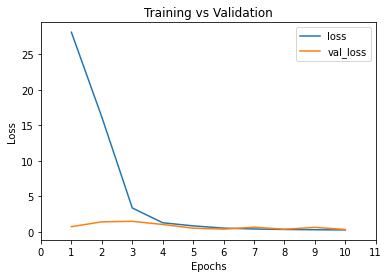

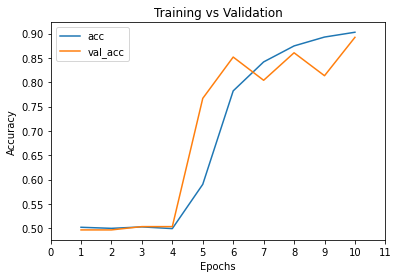

Training done in 27m 21s
---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2269    245
        -ve    295   2191
---------------------------------------------------
precision:0.8849, recall:0.9025
F1-score :0.8937
accuracy :0.8920
---------------------------------------------------


In [87]:
EMBED_SIZE = best_t['EMBED_SIZE']
HIDDEN_SIZE = best_t['HIDDEN_SIZE']
num_heads = best_t['num_heads']
n_layers = best_t['n_layers']
dropout = best_t['dropout']
LR = best_t['LR']

CHECKPOINT_PATH = 'para/transformer_new.pth'
#-----------------------------------------------------

transformer_new = Transformer_new(vocab_size, EMBED_SIZE, num_heads, HIDDEN_SIZE, n_layers, MAX_LEN, dropout).to(device)
transformer_new = gen_final(transformer_new)

## Final model results by IMDB test set

In [89]:
confusion_m, acc, precision, recall = performance(final_LSTM, test_dl, binaryloss=True)

---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2272    233
        -ve    318   2177
---------------------------------------------------
precision:0.8772, recall:0.9070
F1-score :0.8919
accuracy :0.8898
---------------------------------------------------


In [90]:
confusion_m, acc, precision, recall = performance(final_GRU, test_dl, binaryloss=True)

---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2246    259
        -ve    296   2199
---------------------------------------------------
precision:0.8836, recall:0.8966
F1-score :0.8900
accuracy :0.8890
---------------------------------------------------


In [91]:
confusion_m, acc, precision, recall = performance(final_attentionLSTM, test_dl, binaryloss=True)

---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2265    240
        -ve    251   2244
---------------------------------------------------
precision:0.9002, recall:0.9042
F1-score :0.9022
accuracy :0.9018
---------------------------------------------------


In [92]:
confusion_m, acc, precision, recall = performance(final_transformer, test_dl, binaryloss=True)

---------------------------------------------------
              Predicted
              +ve    -ve
Actual  +ve   2241    264
        -ve    319   2176
---------------------------------------------------
precision:0.8754, recall:0.8946
F1-score :0.8849
accuracy :0.8834
---------------------------------------------------


In [93]:
print(best_l)
print(best_g)
print(best_a)
print(best_t)

{'dropout': 0.6, 'LR': 0.001, 'EMBED_SIZE': 256, 'HIDDEN_SIZE': 1024}
{'dropout': 0.5, 'LR': 0.001, 'EMBED_SIZE': 512, 'HIDDEN_SIZE': 512}
{'dropout': 0.5, 'LR': 0.001, 'EMBED_SIZE': 512, 'HIDDEN_SIZE': 1024}
{'dropout': 0.25, 'LR': 0.0003, 'EMBED_SIZE': 128, 'HIDDEN_SIZE': 2048, 'num_heads': 4, 'n_layers': 4}
